In [316]:
import os
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas()

from sklearn.preprocessing import *
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN 
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

from scipy import stats
import scikit_posthocs as sp
import pingouin as pg

import warnings
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.cm as cm
import seaborn as sns
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

In [317]:
data = pd.read_csv("../Data/Preprocessed/사용자_충전_가맹점분류.csv", encoding='cp949')

In [319]:
data.isna().sum()

사용자코드          0
총 사용금액         0
사용빈도           0
1회당 평균 사용금액    0
다른지역소비비율       0
골목상권소비비율       0
자가충전비율         0
성별             0
연령대            0
읍/면            0
기간             0
dtype: int64

In [320]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128524 entries, 0 to 128523
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   사용자코드        128524 non-null  object 
 1   총 사용금액       128524 non-null  int64  
 2   사용빈도         128524 non-null  int64  
 3   1회당 평균 사용금액  128524 non-null  float64
 4   다른지역소비비율     128524 non-null  float64
 5   골목상권소비비율     128524 non-null  float64
 6   자가충전비율       128524 non-null  float64
 7   성별           128524 non-null  object 
 8   연령대          128524 non-null  object 
 9   읍/면          128524 non-null  object 
 10  기간           128524 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 10.8+ MB


## 이상치 확인 및 제거

In [ ]:
df_0 = data.loc[data['기간'] == 2020]
df_1 = data.loc[data['기간'] == 2021]
df_2 = data.loc[data['기간'] == 2022]

def detect_outlier(df):
    column = '총 사용금액'
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    data_filt = df[((df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR))] 
    outliers = df[~((df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR))]
    return data_filt, outliers

data0, outliers0 = detect_outlier(df_0)
data1, outliers1 = detect_outlier(df_1)
data2, outliers2 = detect_outlier(df_2) 

data = pd.concat([data0, data1, data2], axis=0)
data = data.sort_values(by=['기간', '읍/면']).reset_index()
data = data.drop('index', axis=1)
data

In [322]:
# def detect_outlier(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     outliers = df[~((df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR))]
#     return outliers 

In [323]:
# cols = ['총 사용금액', '1회당 평균 사용금액']
# outliers_df = pd.DataFrame()
# for period in data['기간'].unique():
#     tmp_df = data.loc[data['기간'] == period]
#     for col in cols:
#         outliers = detect_outlier(tmp_df, col)
#         if not outliers.empty:
#             outliers['기간'] = period
#             outliers['이상치 발견변수'] = col 
#             outliers_df = pd.concat([outliers_df, outliers])

In [324]:
# outliers_df = outliers_df.drop_duplicates(subset=['기간', '사용자코드'], keep='first')
# outliers_df.to_csv("../Result/0100. 고객 세그멘테이션(우수 사용자_VIP)/고객이상치.csv", index=False, encoding='cp949')    ####이상치 값 저장
# outliers_df = outliers_df[['사용자코드', '기간']]
# outliers_df

In [325]:
# result_df = pd.merge(data, outliers_df, on=['사용자코드', '기간'], how='left', indicator=True)
# result_df = result_df[result_df['_merge'] != 'both']
# result_df.drop(columns='_merge', inplace=True)
# result_df

In [326]:
# len(data) - len(outliers_df)

In [327]:
# data = result_df.copy()
# data

## 변수선택

In [328]:
data.columns

Index(['사용자코드', '총 사용금액', '사용빈도', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율',
       '자가충전비율', '성별', '연령대', '읍/면', '기간'],
      dtype='object')

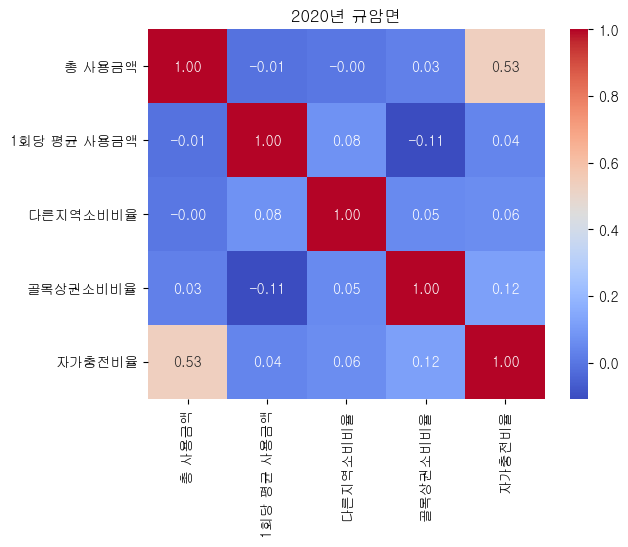

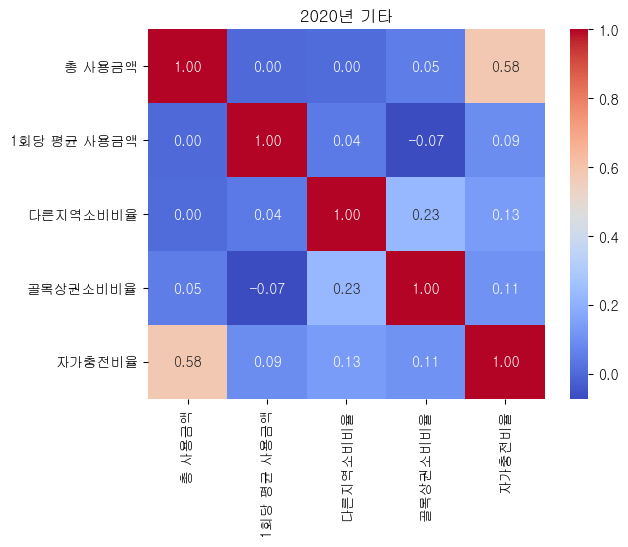

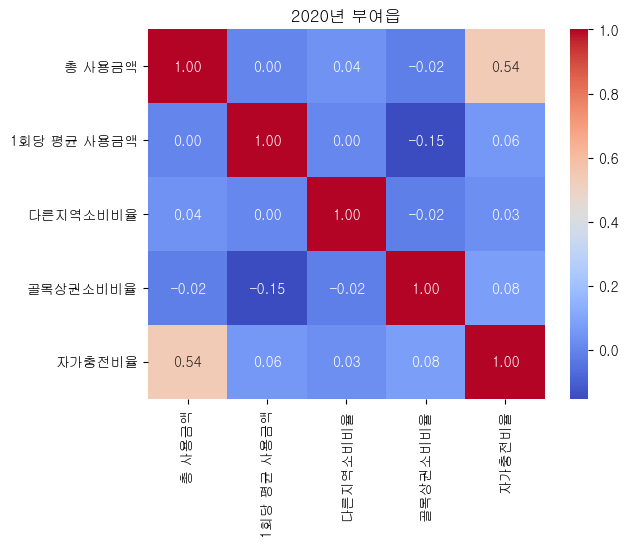

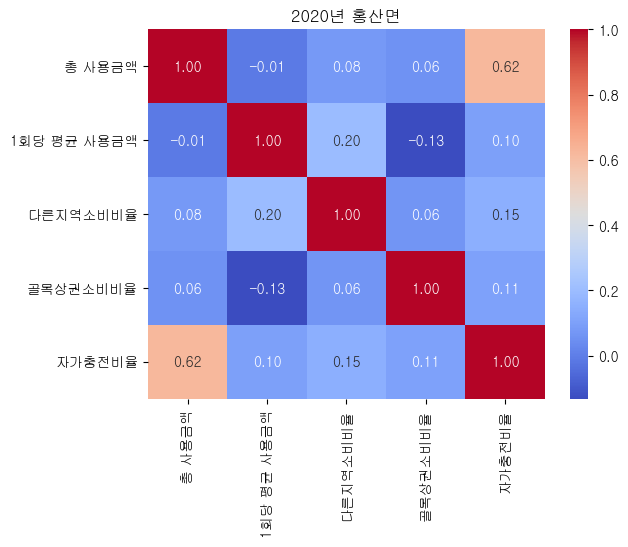

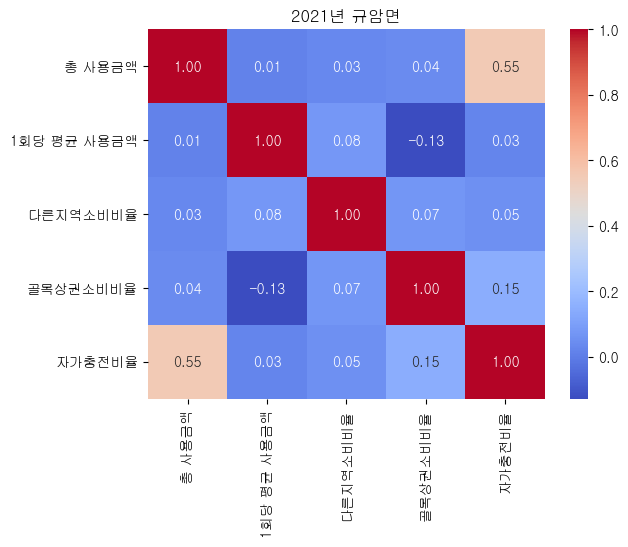

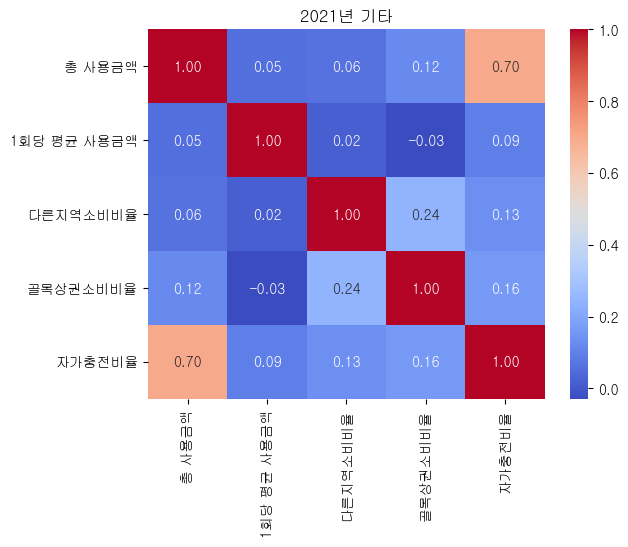

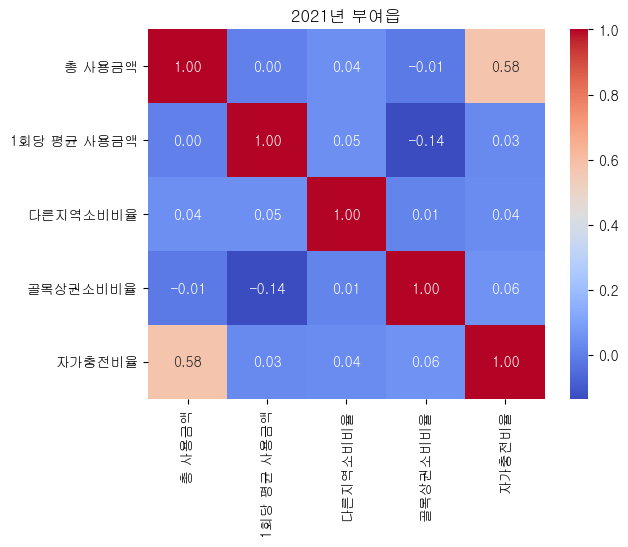

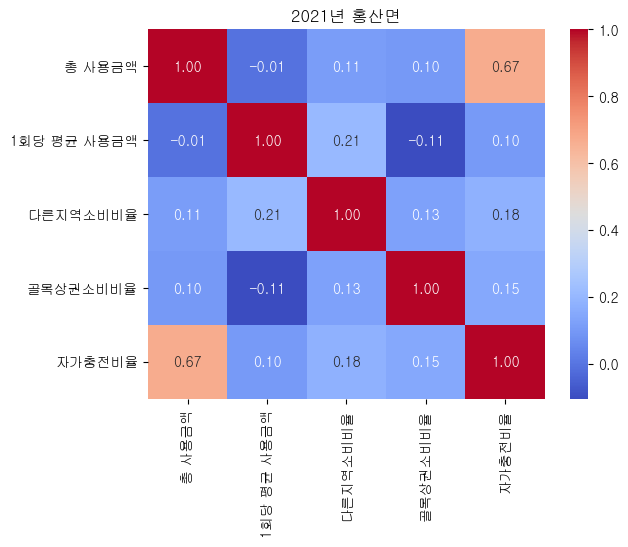

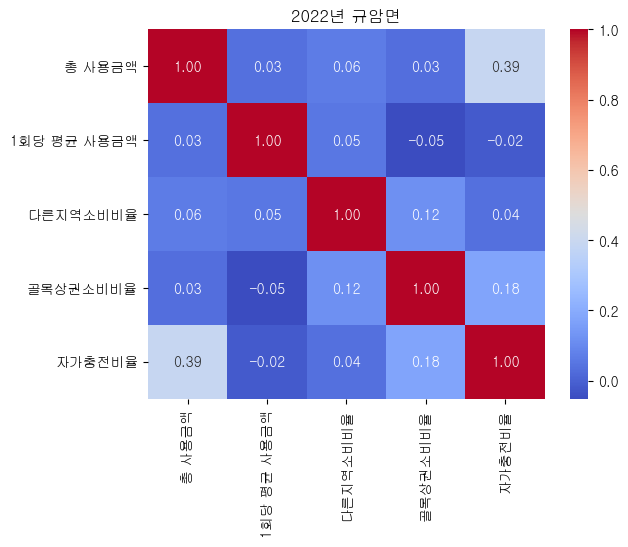

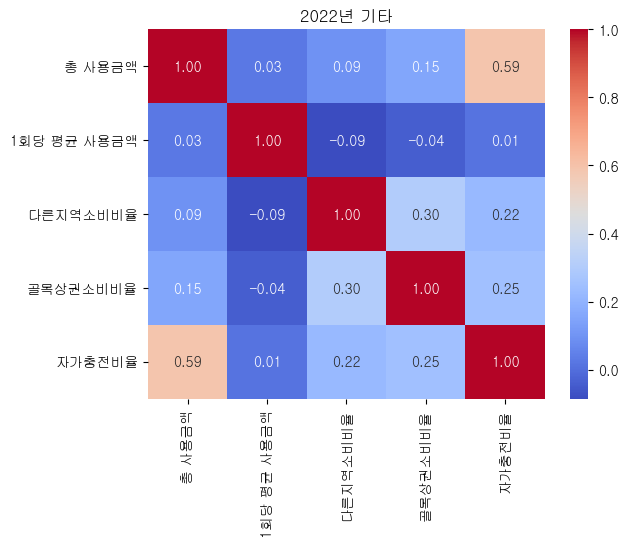

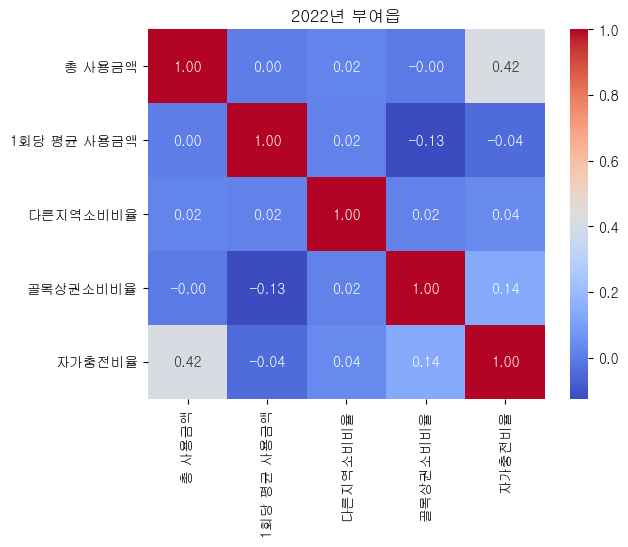

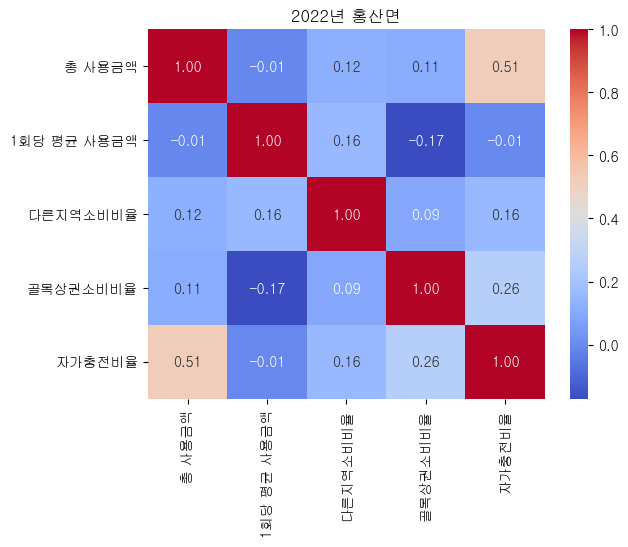

In [329]:
for period in data['기간'].unique():
    data_period = data[data['기간'] == period]
    for area in data_period['읍/면'].unique():
        data_area = data_period[data_period['읍/면'] == area]
        data_corr = data_area[['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']]

        plt.title(f'{period}년 {area}')
        sns.heatmap(data=data_corr.corr(), annot=True, fmt='.2f', cmap='coolwarm')
        plt.show()

In [330]:
#다중공선성 
for period in data['기간'].unique():
    data_period = data[data['기간'] == period]
    for area in data_period['읍/면'].unique():
        data_area = data_period[data_period['읍/면'] == area]
        columns = ['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']
        data_vif = data_area[columns]
        vif_data = pd.DataFrame()
        vif_data["feature"] = columns
        vif_data["VIF"] = [variance_inflation_factor(data_vif, i) for i in range(data_vif.shape[1])]
        print(f"{period}년 {area}:", vif_data)

2020년 규암면:        feature       VIF
0       총 사용금액  2.604057
1  1회당 평균 사용금액  1.250901
2     다른지역소비비율  2.964205
3     골목상권소비비율  2.293218
4       자가충전비율  2.248983
2020년 기타:        feature       VIF
0       총 사용금액  2.354803
1  1회당 평균 사용금액  1.301282
2     다른지역소비비율  2.000709
3     골목상권소비비율  1.722805
4       자가충전비율  1.922476
2020년 부여읍:        feature       VIF
0       총 사용금액  2.390190
1  1회당 평균 사용금액  1.159543
2     다른지역소비비율  1.165277
3     골목상권소비비율  1.543378
4       자가충전비율  2.233212
2020년 홍산면:        feature       VIF
0       총 사용금액  2.651528
1  1회당 평균 사용금액  1.295564
2     다른지역소비비율  1.911486
3     골목상권소비비율  1.619247
4       자가충전비율  2.271052
2021년 규암면:        feature       VIF
0       총 사용금액  2.498656
1  1회당 평균 사용금액  1.222848
2     다른지역소비비율  3.025195
3     골목상권소비비율  2.332249
4       자가충전비율  3.552540
2021년 기타:        feature       VIF
0       총 사용금액  2.953276
1  1회당 평균 사용금액  1.217581
2     다른지역소비비율  1.869657
3     골목상권소비비율  1.716829
4       자가충전비율  3.212269
2021년 부여읍:        feature       VIF


## 군집분석

In [331]:
##스케일링 
## standard로 진행 재시도 필요
def scale_data(df, scaler=None):
    scaler = StandardScaler()
    columns = ['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']
    data_X = df[columns]
    data_X_sc = scaler.fit_transform(data_X)
    scaled_df = pd.DataFrame(data_X_sc, columns=columns, index=df.index)
    return scaled_df

In [332]:
##스케일링 
scaled_data_list = []
for period in data['기간'].unique():
    data_period = data[data['기간'] == period]
    for area in data_period['읍/면'].unique():
        data_area = data_period[data_period['읍/면'] == area]
        scaled_data = scale_data(data_area)
        scaled_data['기간'] = period
        scaled_data['읍/면'] = area
        scaled_data_list.append(scaled_data)

data_sc = pd.concat(scaled_data_list, ignore_index=True)

In [333]:
data_sc

,총 사용금액,1회당 평균 사용금액,다른지역소비비율,골목상권소비비율,자가충전비율,기간,읍/면
0,-0.902831,0.157663,1.111151,-1.260237,-0.757184,2020,규암면
1,-0.677559,-0.187867,-1.855263,-1.260237,-0.757184,2020,규암면
2,0.112212,-0.189074,0.849253,-0.714112,1.766896,2020,규암면
3,-0.576945,-0.206529,1.017136,-0.923216,-0.757184,2020,규암면
4,-0.779543,-0.147972,-2.211176,-1.260237,-0.757184,2020,규암면
...,...,...,...,...,...,...,...
117313,2.103686,0.041806,0.730599,0.616733,1.282310,2022,홍산면
117314,-0.188660,-0.411692,-0.355761,-0.122146,1.272744,2022,홍산면
117315,-0.634626,-0.410544,-0.868828,-0.890041,-0.995308,2022,홍산면
117316,0.300005,-0.131436,-0.415662,0.082190,0.207958,2022,홍산면


#### 군집개수 결정

2020년 규암면
군집 수: 2, 실루엣 스코어: 0.3237
군집 수: 3, 실루엣 스코어: 0.3306
군집 수: 4, 실루엣 스코어: 0.2961
군집 수: 5, 실루엣 스코어: 0.3007
군집 수: 6, 실루엣 스코어: 0.3130
군집 수: 7, 실루엣 스코어: 0.3083
군집 수: 8, 실루엣 스코어: 0.3028
군집 수: 9, 실루엣 스코어: 0.2757
군집 수: 10, 실루엣 스코어: 0.2800


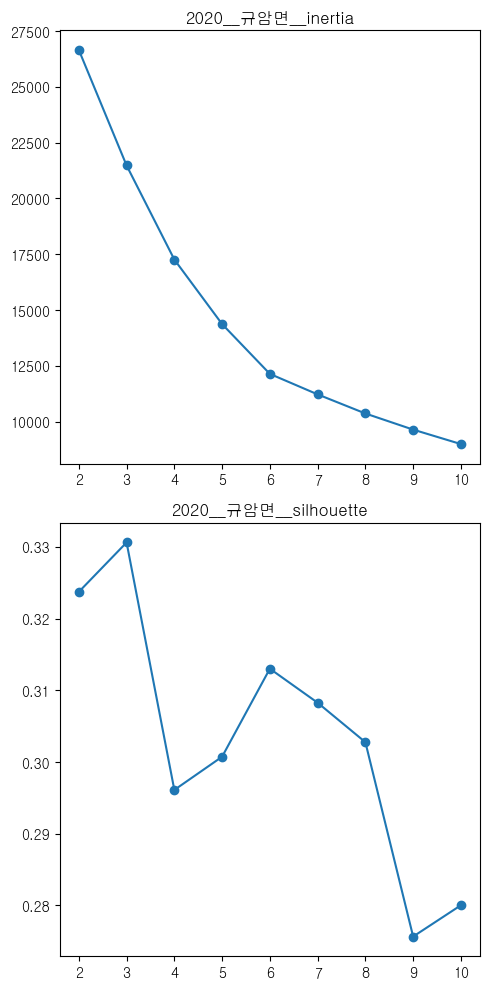

2020년 기타
군집 수: 2, 실루엣 스코어: 0.4037
군집 수: 3, 실루엣 스코어: 0.3077
군집 수: 4, 실루엣 스코어: 0.3225
군집 수: 5, 실루엣 스코어: 0.3390
군집 수: 6, 실루엣 스코어: 0.3424
군집 수: 7, 실루엣 스코어: 0.3493
군집 수: 8, 실루엣 스코어: 0.3164
군집 수: 9, 실루엣 스코어: 0.3284
군집 수: 10, 실루엣 스코어: 0.3094


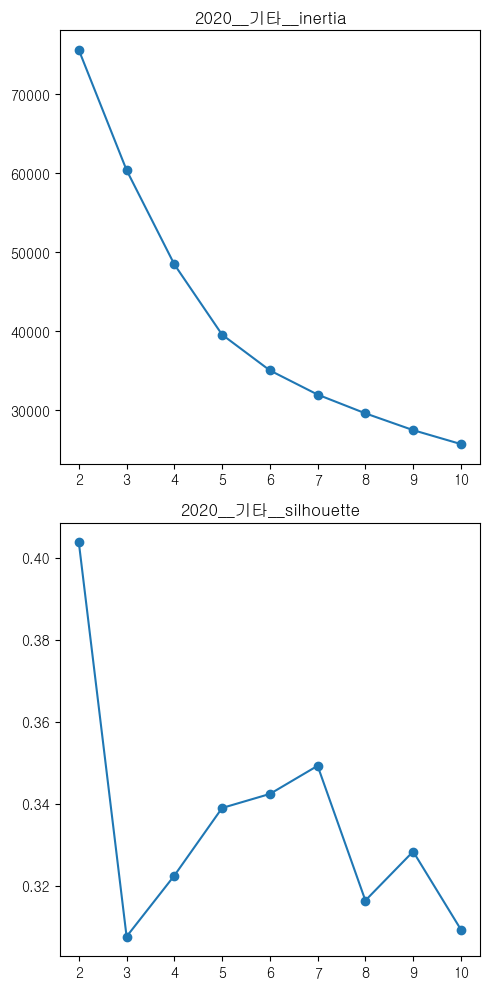

2020년 부여읍
군집 수: 2, 실루엣 스코어: 0.3515
군집 수: 3, 실루엣 스코어: 0.3595
군집 수: 4, 실루엣 스코어: 0.3880
군집 수: 5, 실루엣 스코어: 0.3541
군집 수: 6, 실루엣 스코어: 0.3604
군집 수: 7, 실루엣 스코어: 0.3490
군집 수: 8, 실루엣 스코어: 0.2889
군집 수: 9, 실루엣 스코어: 0.3009
군집 수: 10, 실루엣 스코어: 0.3038


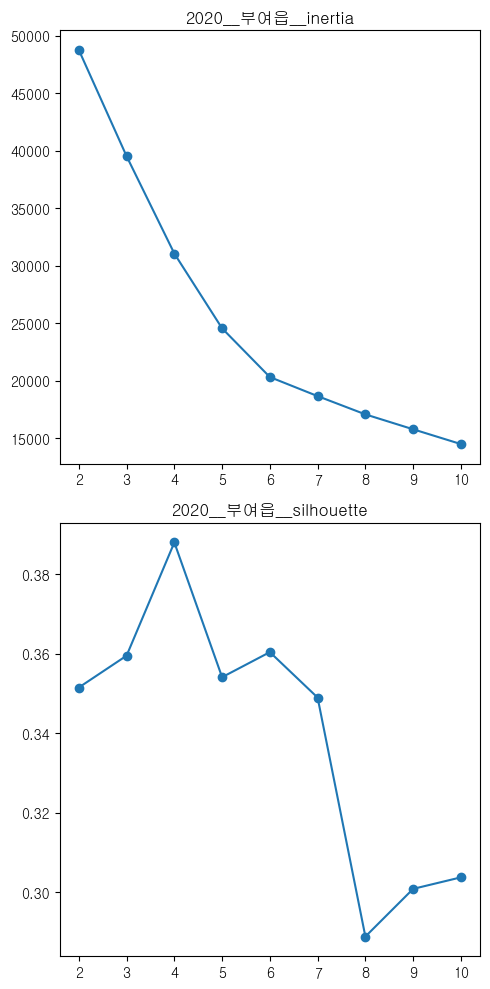

2020년 홍산면
군집 수: 2, 실루엣 스코어: 0.3828
군집 수: 3, 실루엣 스코어: 0.3824
군집 수: 4, 실루엣 스코어: 0.3213
군집 수: 5, 실루엣 스코어: 0.3429
군집 수: 6, 실루엣 스코어: 0.3365
군집 수: 7, 실루엣 스코어: 0.3012
군집 수: 8, 실루엣 스코어: 0.3064
군집 수: 9, 실루엣 스코어: 0.3007
군집 수: 10, 실루엣 스코어: 0.3035


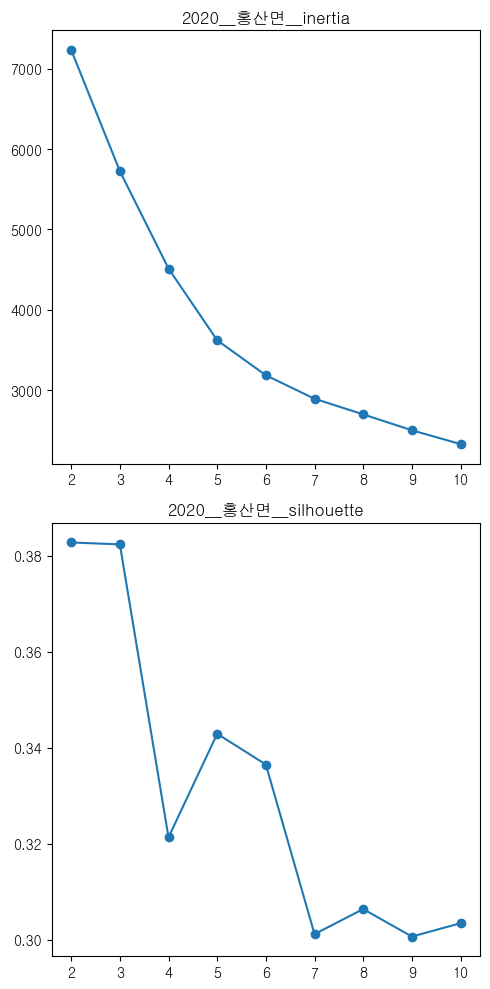

2021년 규암면
군집 수: 2, 실루엣 스코어: 0.3216
군집 수: 3, 실루엣 스코어: 0.3366
군집 수: 4, 실루엣 스코어: 0.3097
군집 수: 5, 실루엣 스코어: 0.3220
군집 수: 6, 실루엣 스코어: 0.3370
군집 수: 7, 실루엣 스코어: 0.3296
군집 수: 8, 실루엣 스코어: 0.3409
군집 수: 9, 실루엣 스코어: 0.3448
군집 수: 10, 실루엣 스코어: 0.3503


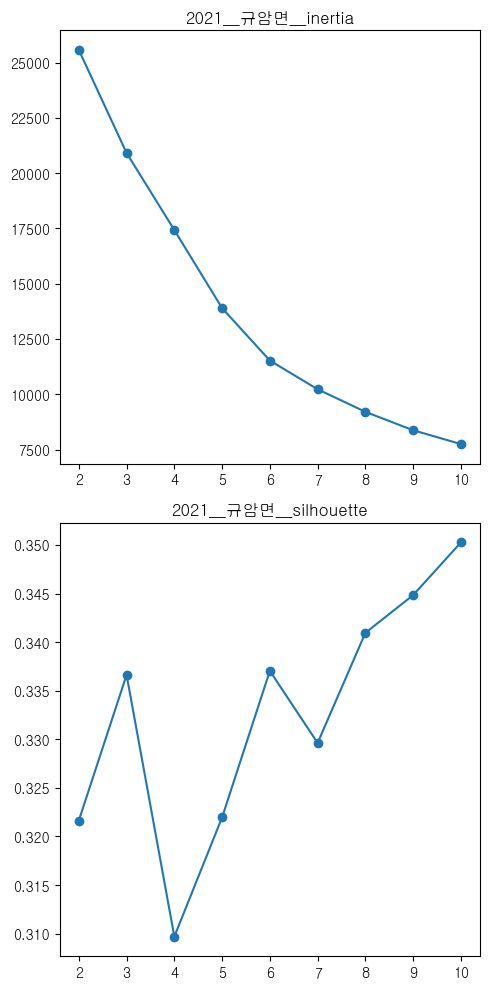

2021년 기타
군집 수: 2, 실루엣 스코어: 0.3719
군집 수: 3, 실루엣 스코어: 0.3480
군집 수: 4, 실루엣 스코어: 0.3681
군집 수: 5, 실루엣 스코어: 0.3858
군집 수: 6, 실루엣 스코어: 0.3938
군집 수: 7, 실루엣 스코어: 0.4055
군집 수: 8, 실루엣 스코어: 0.4100
군집 수: 9, 실루엣 스코어: 0.3964
군집 수: 10, 실루엣 스코어: 0.4144


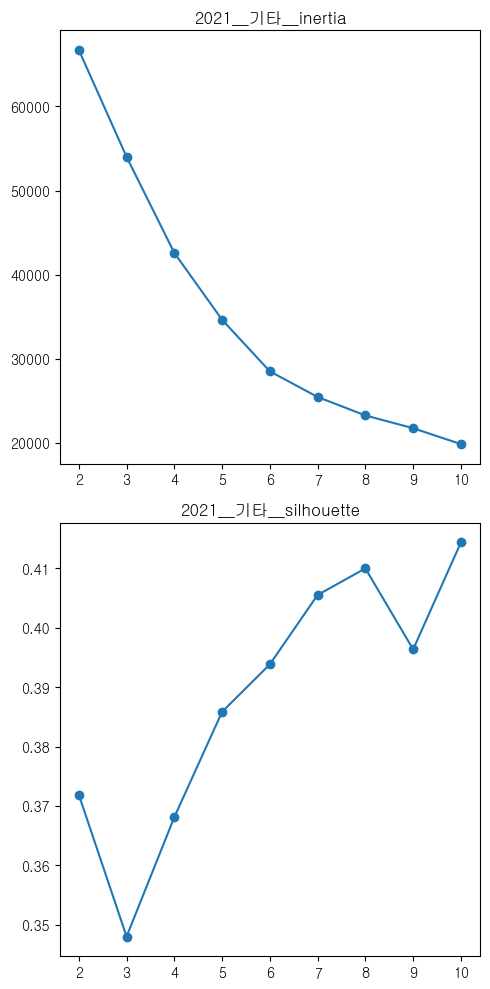

2021년 부여읍
군집 수: 2, 실루엣 스코어: 0.3439
군집 수: 3, 실루엣 스코어: 0.3676
군집 수: 4, 실루엣 스코어: 0.3841
군집 수: 5, 실루엣 스코어: 0.3774
군집 수: 6, 실루엣 스코어: 0.3803
군집 수: 7, 실루엣 스코어: 0.3726
군집 수: 8, 실루엣 스코어: 0.3794
군집 수: 9, 실루엣 스코어: 0.3828
군집 수: 10, 실루엣 스코어: 0.3569


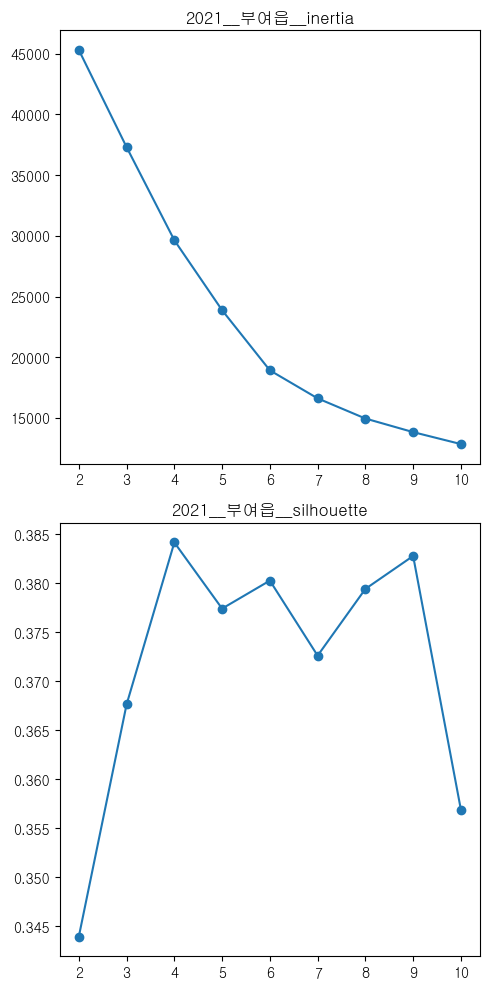

2021년 홍산면
군집 수: 2, 실루엣 스코어: 0.3528
군집 수: 3, 실루엣 스코어: 0.3662
군집 수: 4, 실루엣 스코어: 0.3695
군집 수: 5, 실루엣 스코어: 0.3777
군집 수: 6, 실루엣 스코어: 0.3671
군집 수: 7, 실루엣 스코어: 0.3736
군집 수: 8, 실루엣 스코어: 0.3765
군집 수: 9, 실루엣 스코어: 0.3800
군집 수: 10, 실루엣 스코어: 0.3854


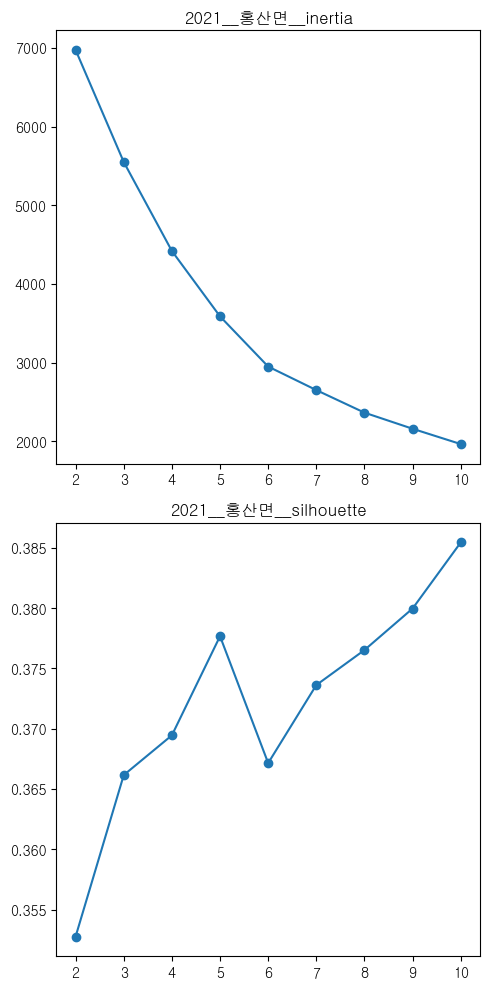

2022년 규암면
군집 수: 2, 실루엣 스코어: 0.2953
군집 수: 3, 실루엣 스코어: 0.2679
군집 수: 4, 실루엣 스코어: 0.2769
군집 수: 5, 실루엣 스코어: 0.2955
군집 수: 6, 실루엣 스코어: 0.2882
군집 수: 7, 실루엣 스코어: 0.2910
군집 수: 8, 실루엣 스코어: 0.2975
군집 수: 9, 실루엣 스코어: 0.2987
군집 수: 10, 실루엣 스코어: 0.3038


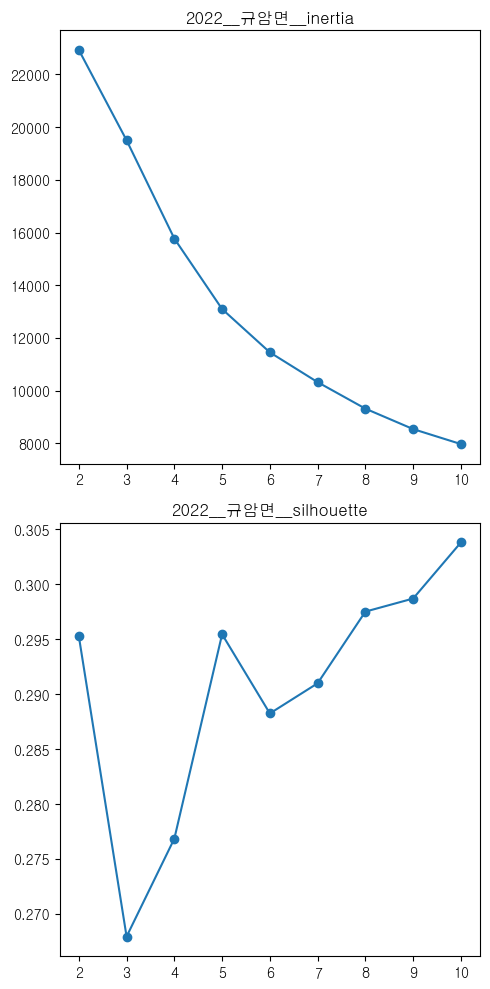

2022년 기타
군집 수: 2, 실루엣 스코어: 0.3440
군집 수: 3, 실루엣 스코어: 0.3000
군집 수: 4, 실루엣 스코어: 0.3189
군집 수: 5, 실루엣 스코어: 0.3234
군집 수: 6, 실루엣 스코어: 0.3252
군집 수: 7, 실루엣 스코어: 0.3371
군집 수: 8, 실루엣 스코어: 0.3393
군집 수: 9, 실루엣 스코어: 0.3355
군집 수: 10, 실루엣 스코어: 0.3096


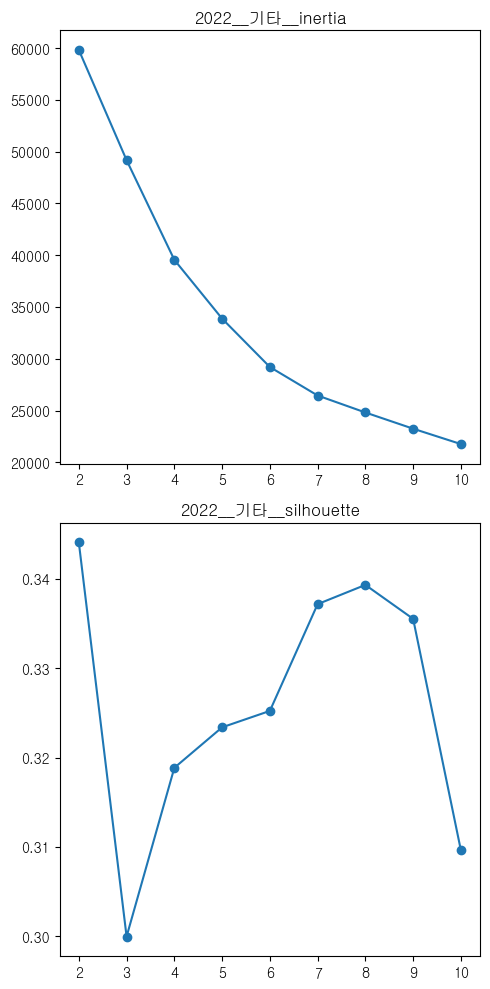

2022년 부여읍
군집 수: 2, 실루엣 스코어: 0.3166
군집 수: 3, 실루엣 스코어: 0.3385
군집 수: 4, 실루엣 스코어: 0.2925
군집 수: 5, 실루엣 스코어: 0.3241
군집 수: 6, 실루엣 스코어: 0.3350
군집 수: 7, 실루엣 스코어: 0.3296
군집 수: 8, 실루엣 스코어: 0.3321
군집 수: 9, 실루엣 스코어: 0.3340
군집 수: 10, 실루엣 스코어: 0.3045


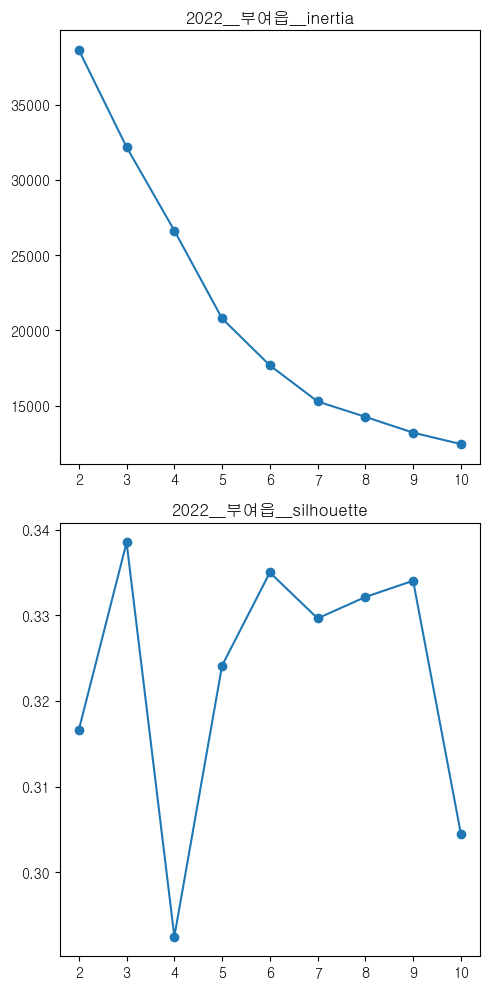

2022년 홍산면
군집 수: 2, 실루엣 스코어: 0.3009
군집 수: 3, 실루엣 스코어: 0.3195
군집 수: 4, 실루엣 스코어: 0.3079
군집 수: 5, 실루엣 스코어: 0.2971
군집 수: 6, 실루엣 스코어: 0.2925
군집 수: 7, 실루엣 스코어: 0.2921
군집 수: 8, 실루엣 스코어: 0.3044
군집 수: 9, 실루엣 스코어: 0.3077
군집 수: 10, 실루엣 스코어: 0.3128


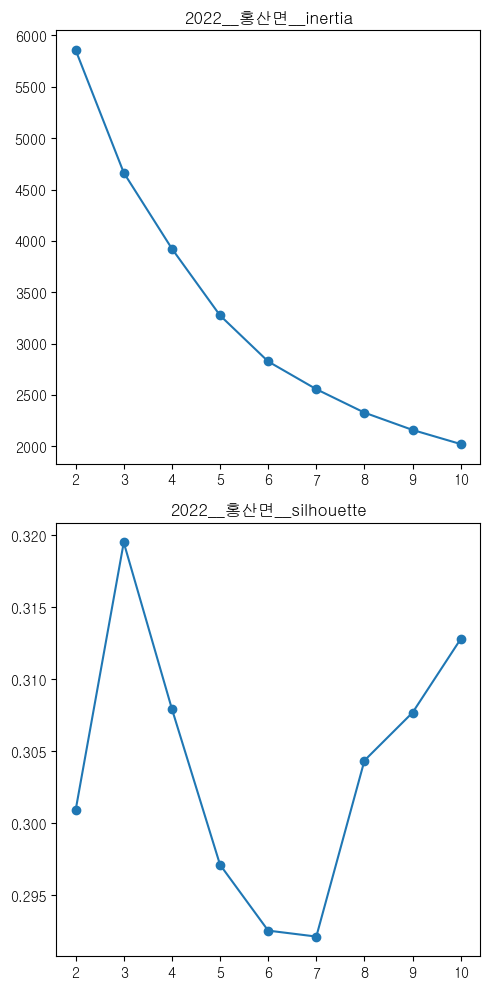

In [334]:
##elbow & silhouette 
for period in data_sc['기간'].unique():
    data_period = data_sc[data_sc['기간'] == period]
    for area in data_period['읍/면'].unique():
        data_area = data_period[data_period['읍/면'] == area]
        data_cluster = data_area[['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']]
        inertia = []
        silhouette_values = []
        for j in range(2, 11):
            kmeans_plus = KMeans(n_clusters = j, init = 'k-means++', random_state=42)
            pred = kmeans_plus.fit_predict(data_cluster)
            inertia.append(kmeans_plus.inertia_)
            silhouette_avg = np.mean(silhouette_samples(data_cluster, pred, metric='euclidean'))
            silhouette_values.append(silhouette_avg)
        
        print(f"{period}년 {area}")
        for i, silhouette_avg in enumerate(silhouette_values):
            print(f"군집 수: {i+2}, 실루엣 스코어: {silhouette_avg:.4f}")

        fig, axs = plt.subplots(2, 1, figsize = (5, 10))
        axs[0].plot(range(2, 11), inertia, marker = 'o')
        axs[0].set_title(f"{period}__{area}__inertia")
        axs[1].plot(range(2, 11), silhouette_values, marker = 'o')
        axs[1].set_title(f"{period}__{area}__silhouette")
        plt.tight_layout()
        plt.show()
        # fig.savefig(f'../Result/가맹점 인센티브 차등적용 기준 수립/Clustering/{row["가맹점 읍면 구분"] + "__" + row["가맹점 골목상권분류"]}.png')

In [335]:
#실루엣 면적 계산 
def visualize_silhouette(cluster_lists, X_features):   
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=42)
        cluster_labels = clusterer.fit_predict(X_features)
        sil_avg = silhouette_score(X_features, cluster_labels, metric='euclidean')
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('군집 수: '+ str(n_cluster)+'\n' \
                          '실루엣 스코어:' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("실루엣 계수")
        axs[ind].set_ylabel("군집")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([]) 
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
           
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
           
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

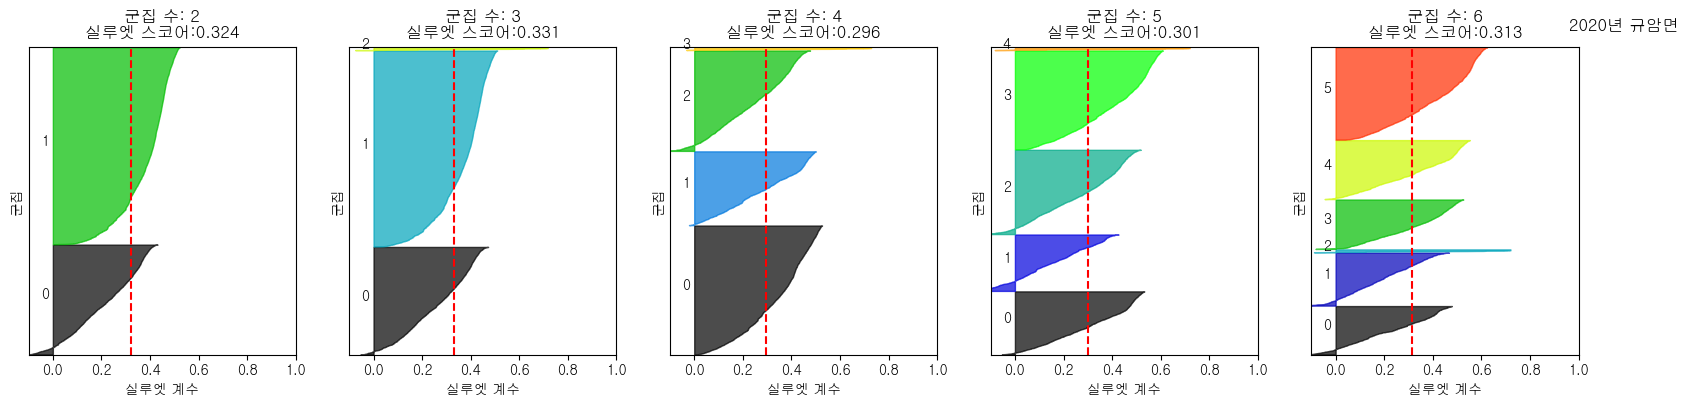

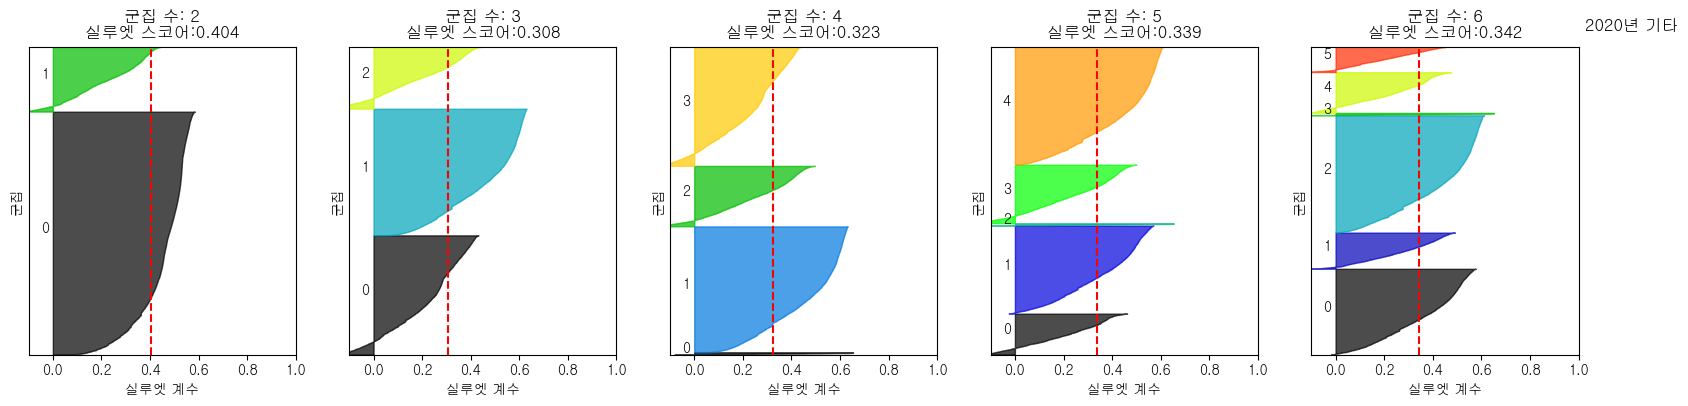

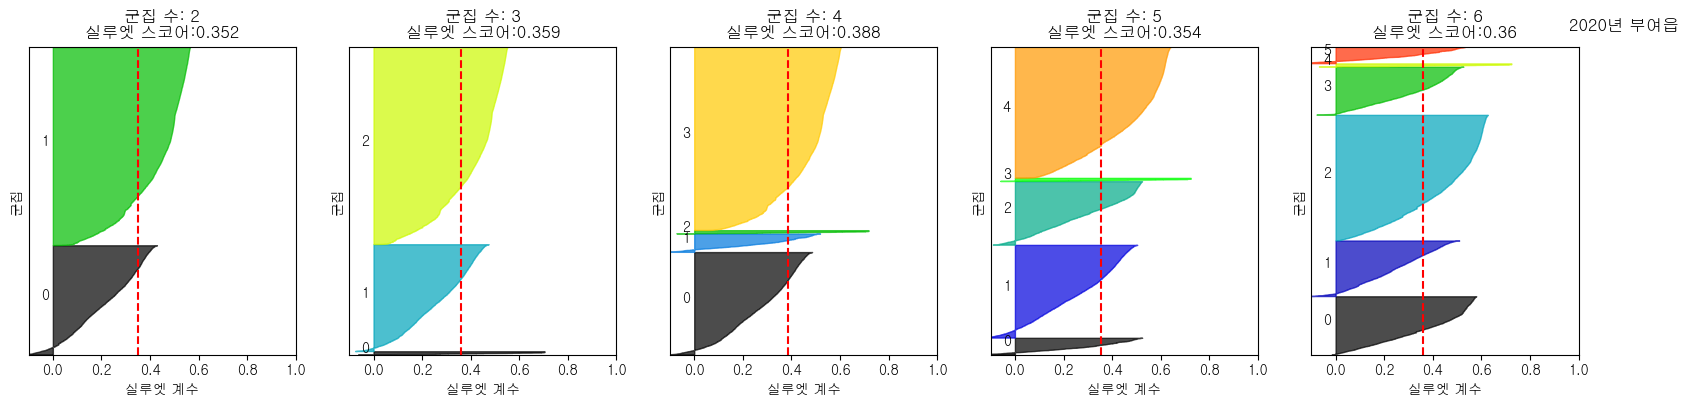

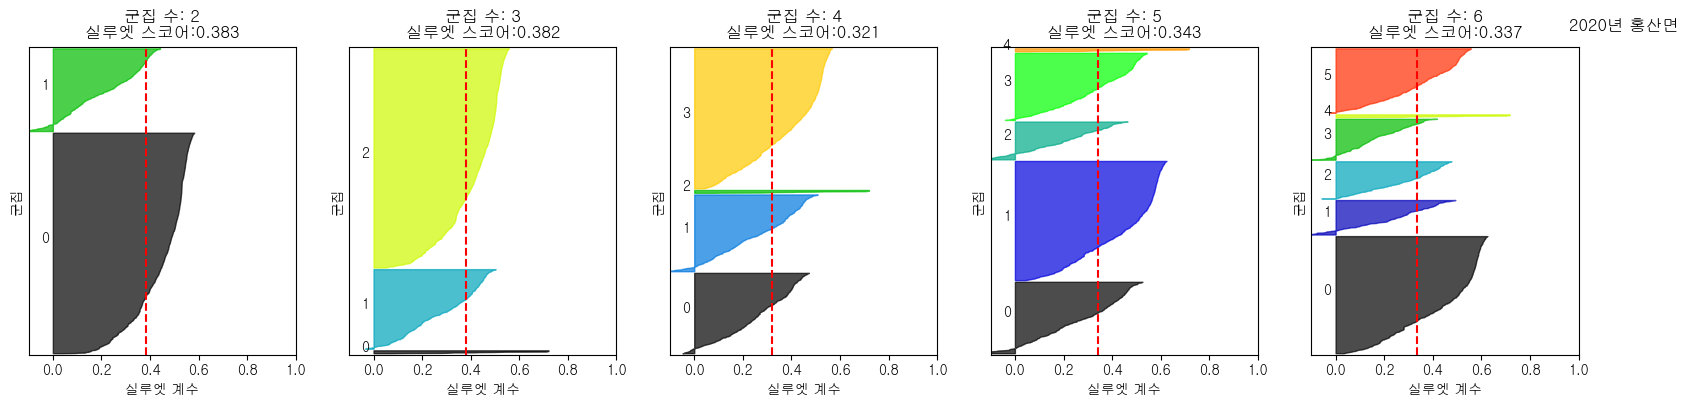

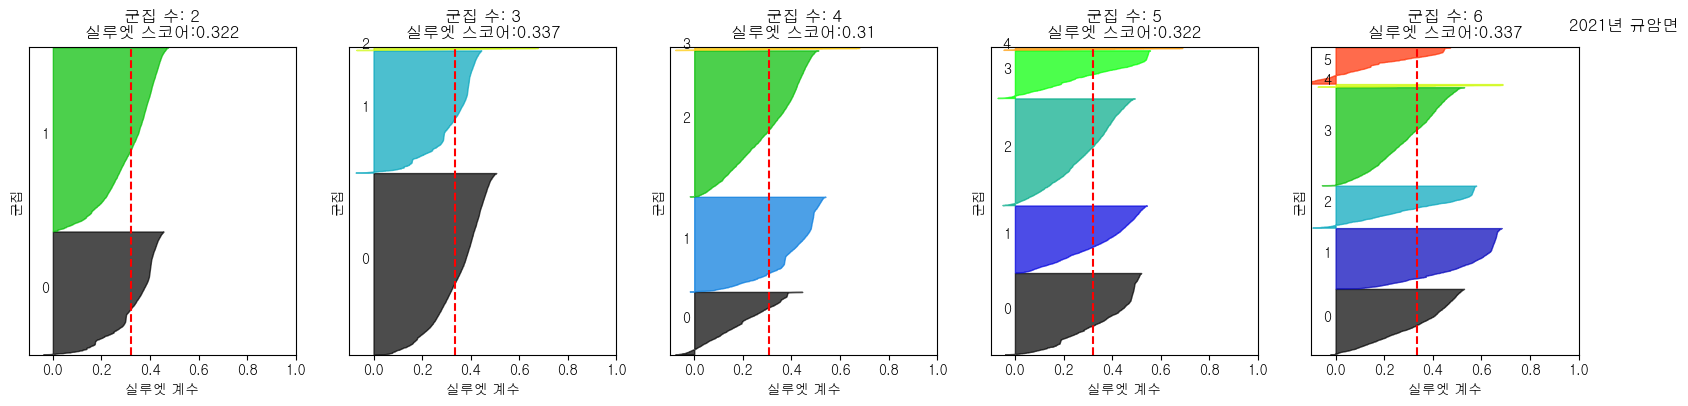

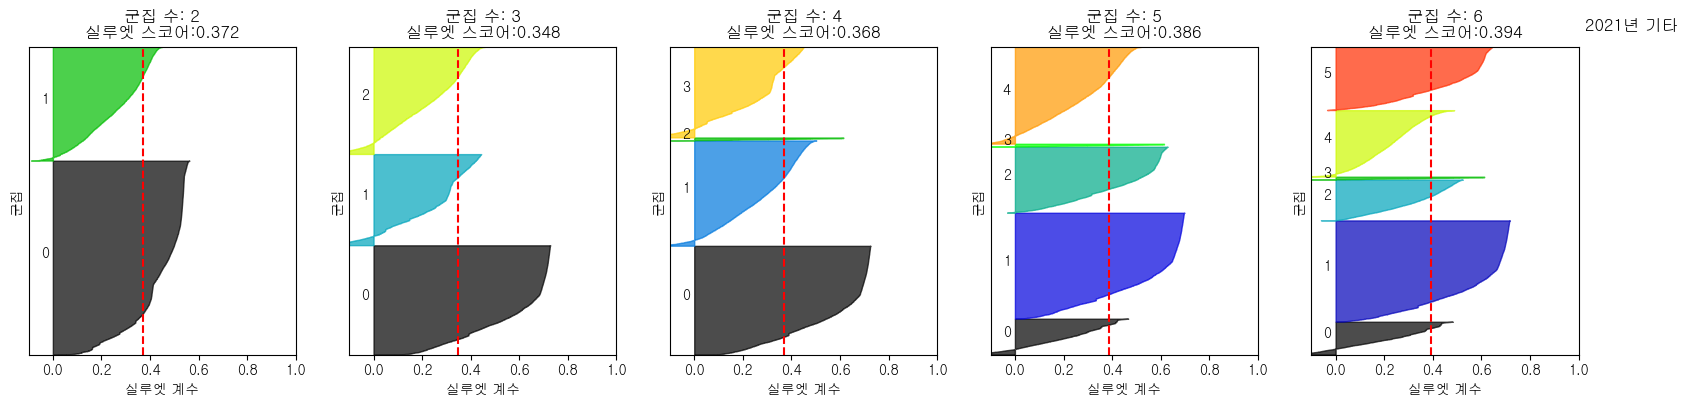

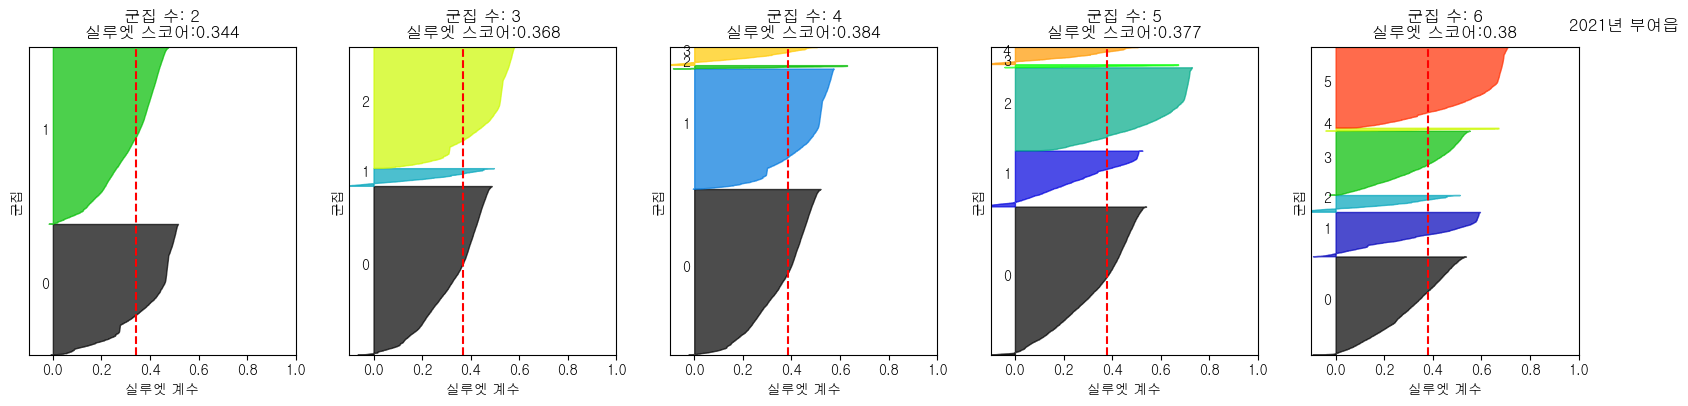

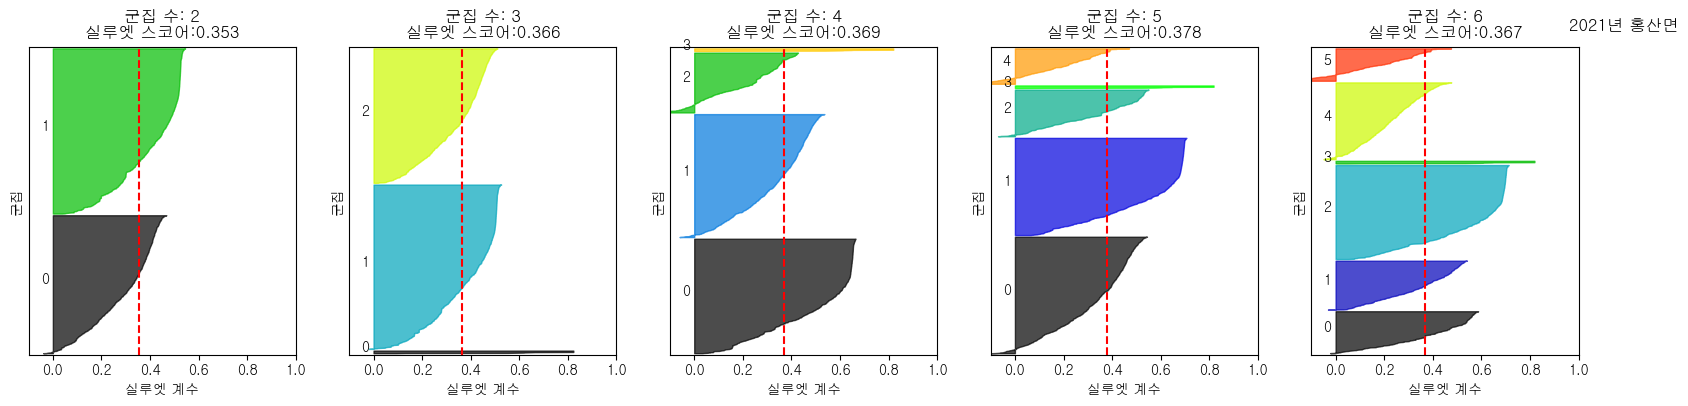

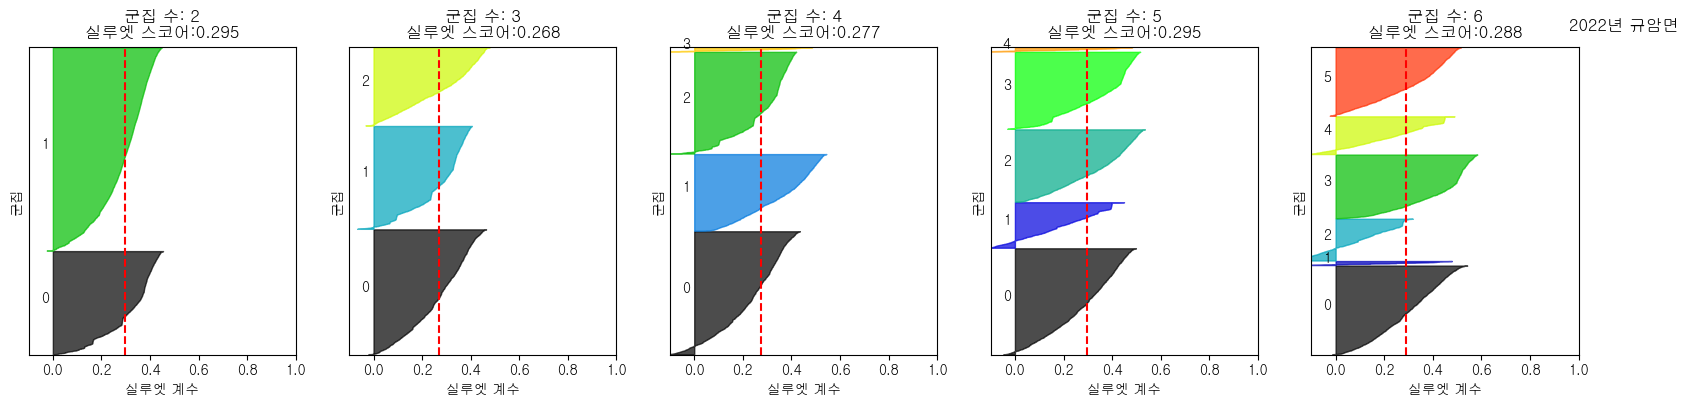

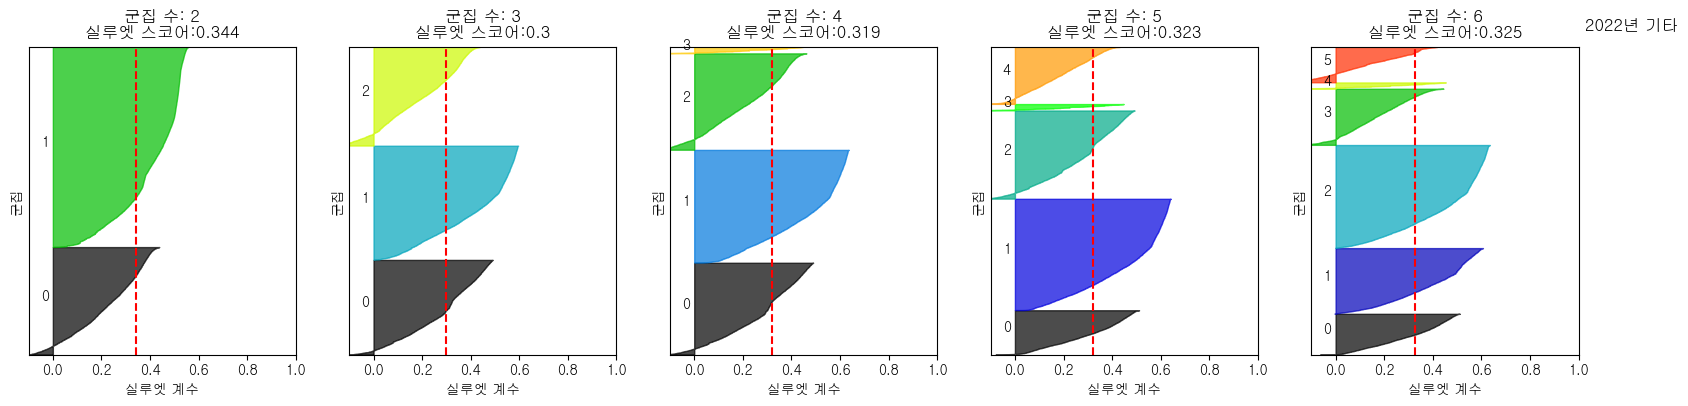

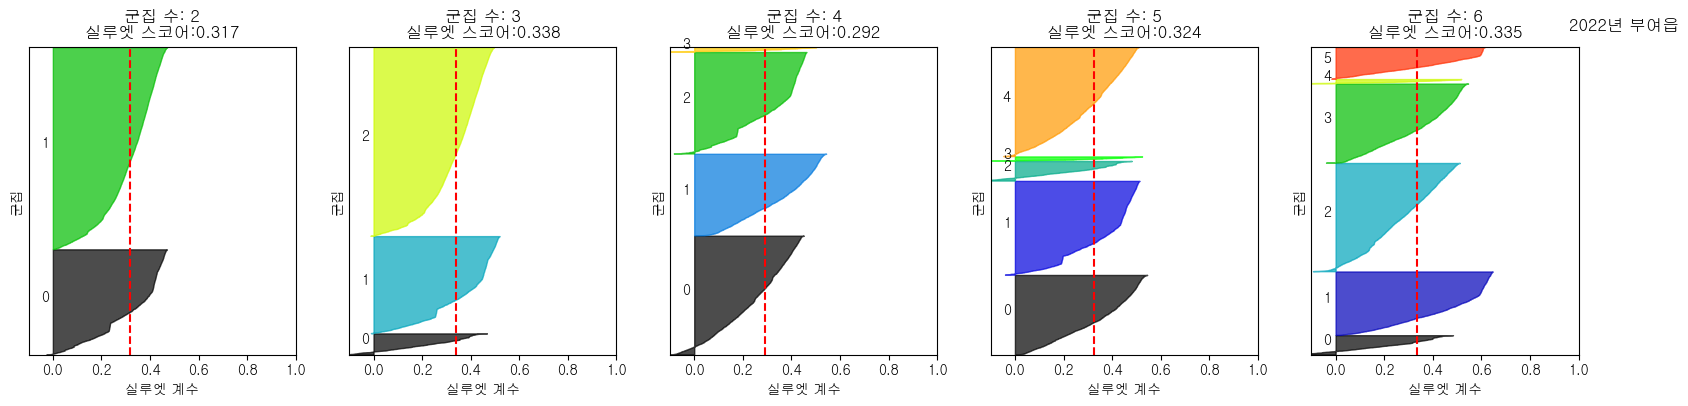

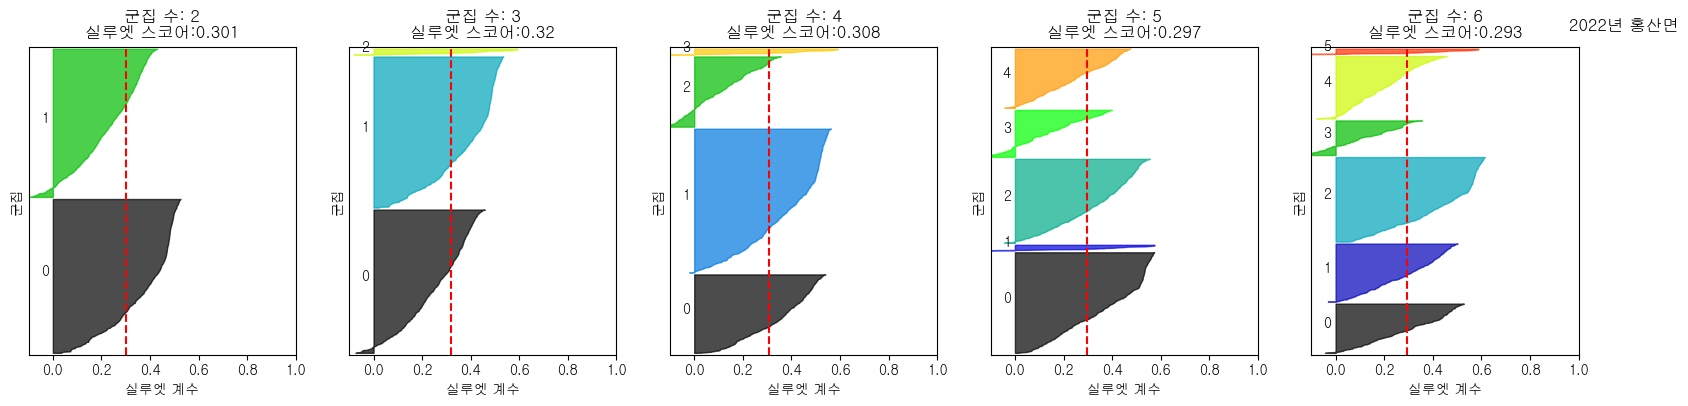

In [336]:
for period in data_sc['기간'].unique():
    data_period = data_sc[data_sc['기간'] == period]
    for area in data_period['읍/면'].unique():
        data_area = data_period[data_period['읍/면'] == area]
        data_cluster = data_area[['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']]
        visualize_silhouette([2, 3, 4, 5, 6], data_cluster)
        plt.suptitle(f"{period}년 {area}", x=0.95, y=0.95, horizontalalignment='right', verticalalignment='top')
        plt.show()

K-Means 군집개수 결과
- 2022년 규암면, 2021년 홍산면: k=5
- 2020년 부여읍, 2021년 부여읍: k=4
- others: k=3

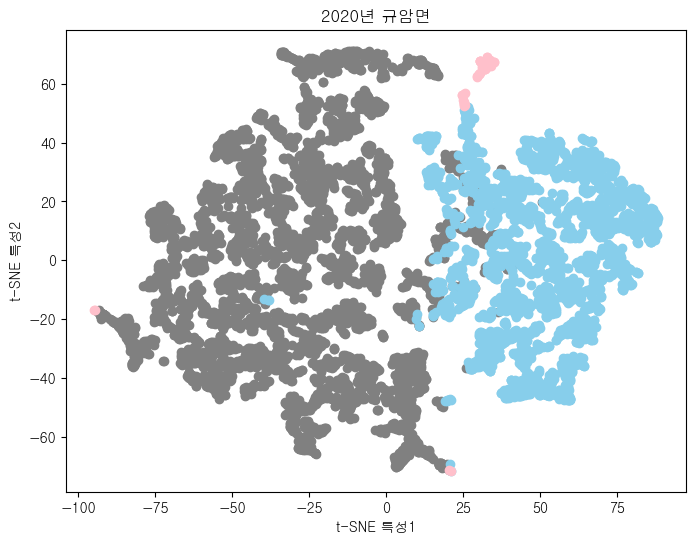

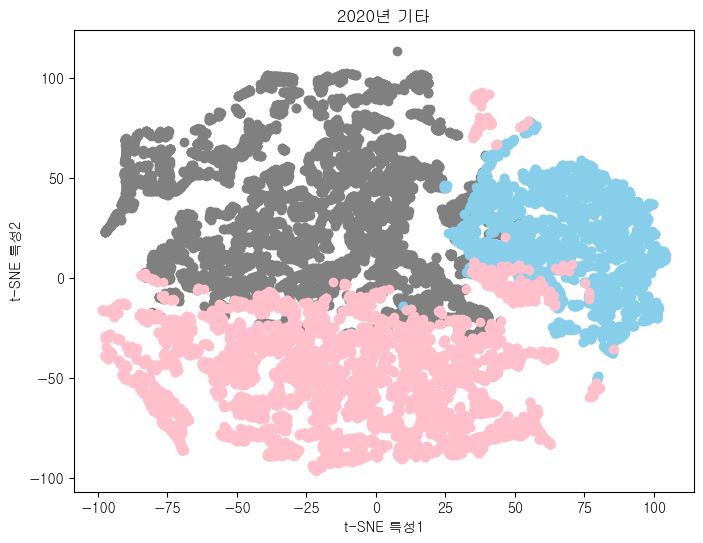

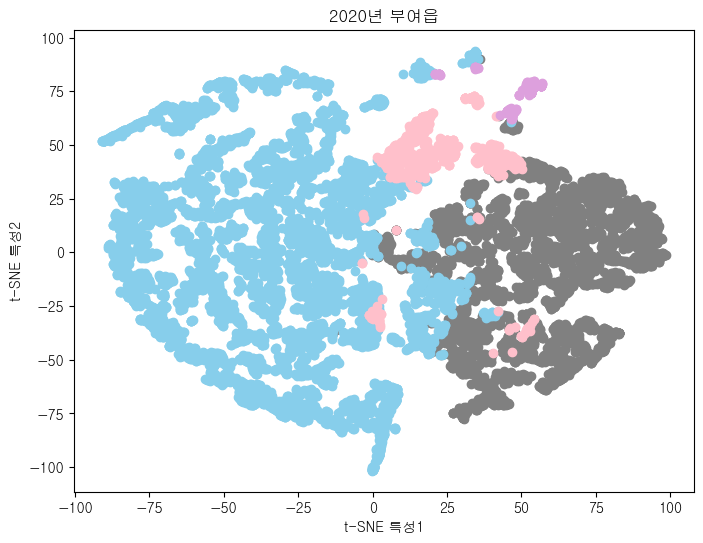

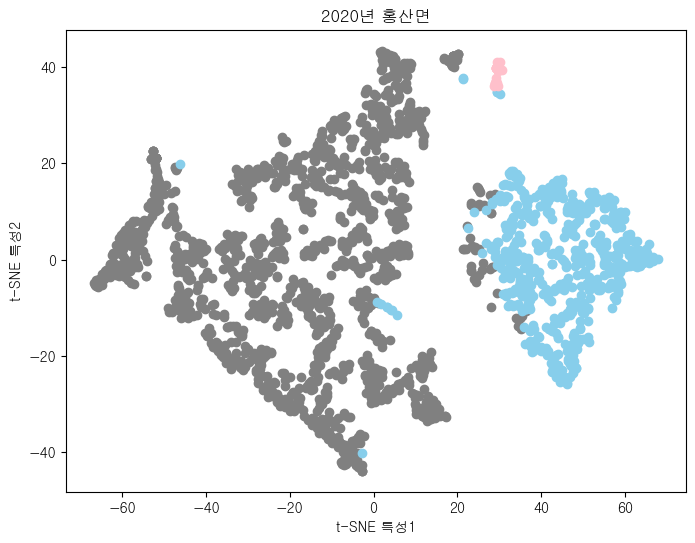

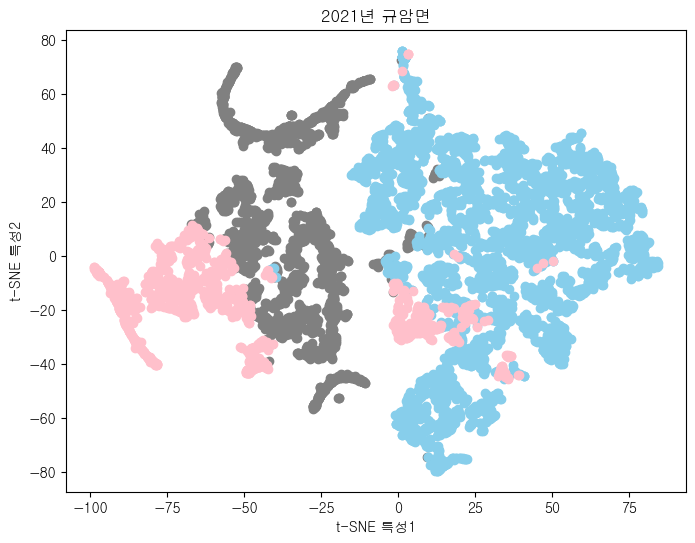

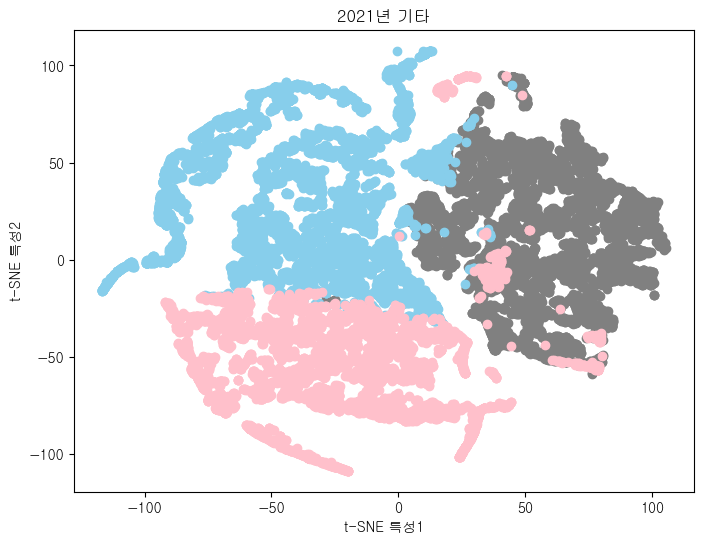

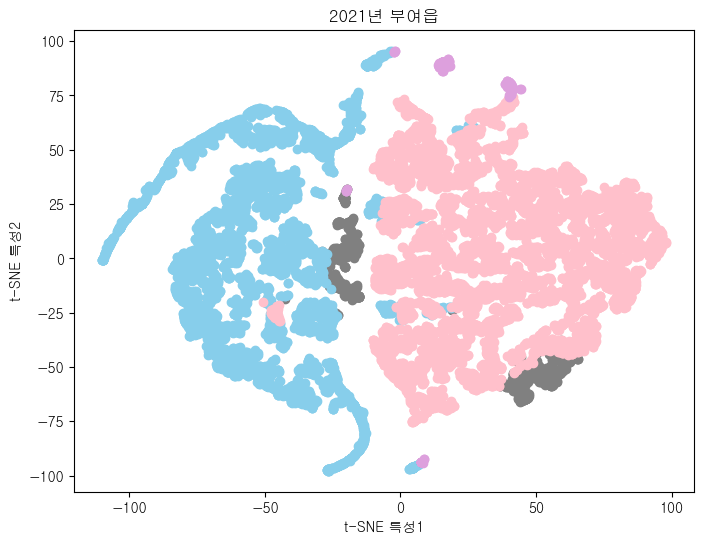

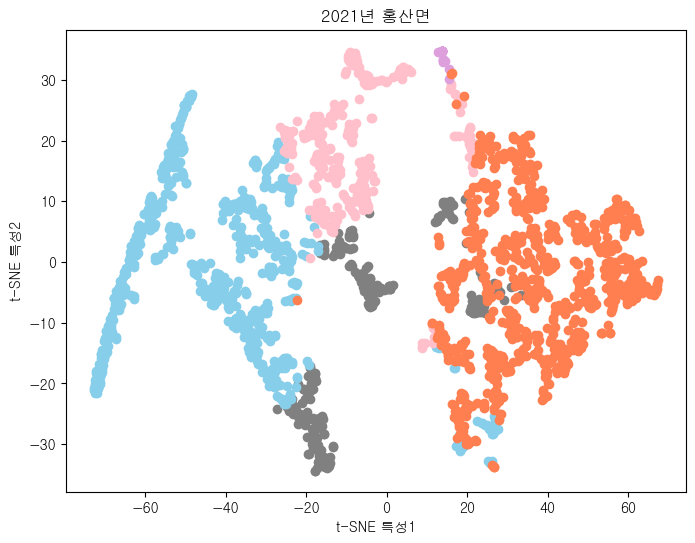

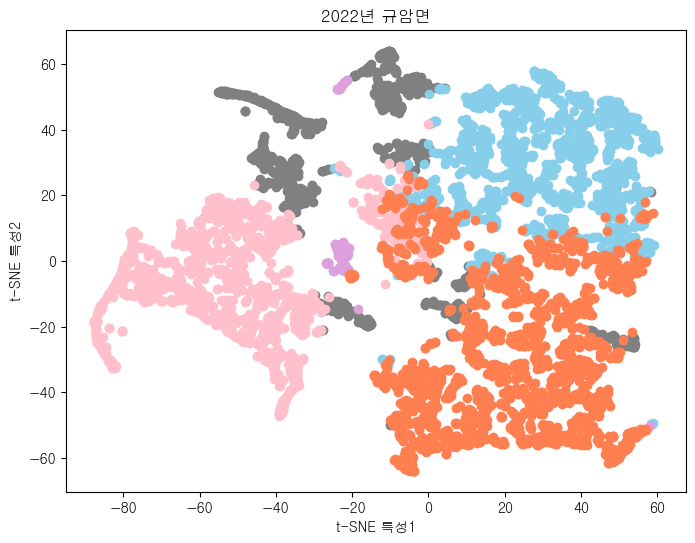

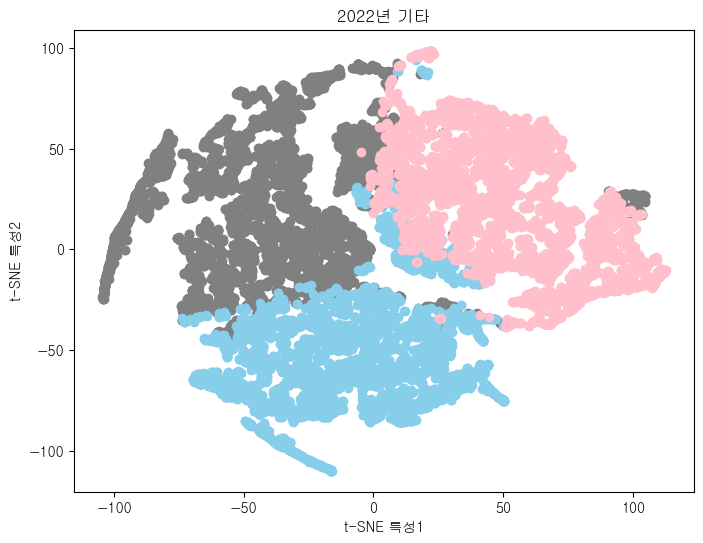

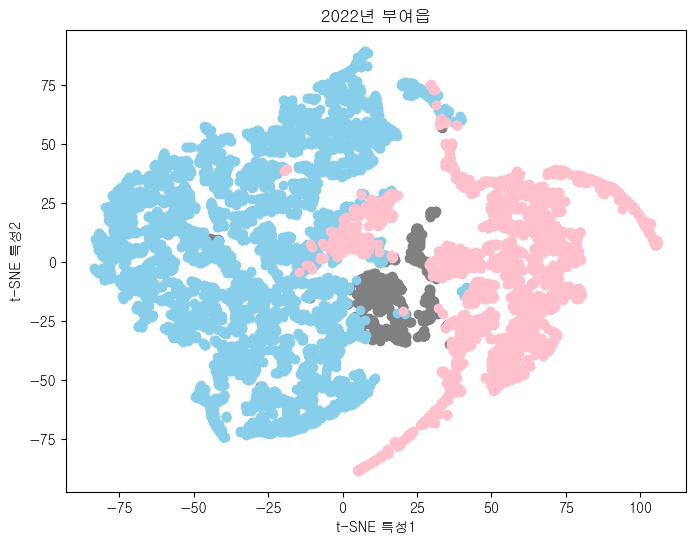

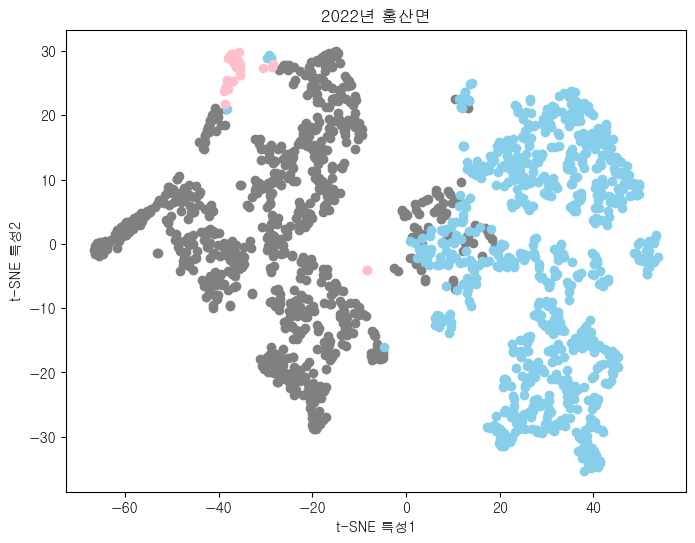

In [371]:
#K-Means 결과 

#label
label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4:'E'} 

data_cluster_list = []
for period in data_sc['기간'].unique():
    data_period = data_sc[data_sc['기간'] == period]
    for area in data_period['읍/면'].unique():
        data_area = data_period[data_period['읍/면'] == area]
        data_area = data_area.reset_index(drop = True)
        data_area = data_area.sort_values(by = ['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율'])

        tmp_data = data.loc[(data['읍/면'] == area) & (data['기간'] == period)]
        tmp_data = tmp_data.sort_values(by = ['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율'])
        
        #data_cluster = data_area[['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']]

        #군집 개수 설정 
        if (period == 2022 and area == '규암면'):
            n_clusters = 5
        elif (period == 2021 and area == '홍산면'):
            n_clusters = 5
        elif (period == 2020 and area == '부여읍'):
            n_clusters = 4
        elif (period == 2021 and area == '부여읍'):
            n_clusters = 4
        else: 
            n_clusters = 3

        ##군집화 
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_clusters = kmeans.fit(data_area[['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']])
        kmeans_labels = kmeans_clusters.labels_
        tmp_data['kmeans_clusters'] = kmeans_clusters.labels_
        data_cluster_list.append(tmp_data)
        # data_cluster_df = pd.concat(data_cluster_list, ignore_index=True)

        # #시각화(PCA)
        # pca = PCA(n_components=2)
        # data_pca = pca.fit_transform(data_area[['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']])
        # data_pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
        # data_pca_df['kmeans_clusters'] = kmeans_clusters.labels_
        # centroids = kmeans_clusters.cluster_centers_
        
        # plt.figure(figsize=(8, 6))
        # colors = ['grey', 'skyblue', 'pink', 'plum', 'coral']
        # for i in range(n_clusters):
        #     cluster_data = data_pca_df[data_pca_df['kmeans_clusters'] == i]
        #     plt.scatter(cluster_data['PC1'], cluster_data['PC2'], color=color, label=f'군집 {cluster_label}')
        # #plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=40, c='red', label='중심점')
        # plt.xlabel('Principal Component 1')
        # plt.ylabel('Principal Component 2')
        # plt.title(f"{period}년 {area}")
        # plt.legend()
        # plt.show()

        #시각화(t-SNE)
        tsne = TSNE(n_components=2, random_state=0)
        digits_tsne = tsne.fit_transform(data_area[['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']])
        data_tsne_df = pd.DataFrame(digits_tsne, columns=['t-SNE 특성1', 't-SNE 특성2'])
        data_tsne_df['kmeans_clusters'] = kmeans_clusters.labels_
        data_tsne_df['kmeans_clusters'] = data_tsne_df['kmeans_clusters'].map(label_map)

        plt.figure(figsize=(8, 6))
        colors = ['grey', 'skyblue', 'pink', 'plum', 'coral']
        plotted_clusters = set()   #keep track of plotted clusters
        for cluster_label, color in zip(label_map.values(), colors):
            cluster_data = data_tsne_df[data_tsne_df['kmeans_clusters'] == cluster_label]
            plt.scatter(cluster_data['t-SNE 특성1'], cluster_data['t-SNE 특성2'], color=color, label=f'군집 {cluster_label}')
            plotted_clusters.add(cluster_label)

        # centroids = kmeans_clusters.cluster_centers_
        # centroids_tsne = tsne.fit_transform(centroids)
        # data_tsne_centroids = pd.DataFrame(centroids_tsne, columns=['t-SNE 특성1', 't-SNE 특성2'])
        # plt.scatter(data_tsne_centroids['t-SNE 특성1'], data_tsne_centroids['t-SNE 특성2'], marker='o', s=40, c='red', label='중심점')

        plt.xlabel('t-SNE 특성1')
        plt.ylabel('t-SNE 특성2')
        plt.title(f"{period}년 {area}")
        #plt.legend(loc='upper right')
        plt.show()

In [365]:
tmp = pd.concat(data_cluster_list, axis = 0, ignore_index = True)

In [367]:
# ##군집분석 결과 저장하기 
# data = data.reset_index()
# data = data.drop('index', axis=1)

# toconcat = data_cluster_df[['kmeans_clusters']]
# cluster_result = pd.concat([data, toconcat], axis=1)
# cluster_result

In [368]:
tmp.groupby(['기간', '읍/면', 'kmeans_clusters']).agg({'총 사용금액': 'mean', '사용빈도' : 'mean', '1회당 평균 사용금액': 'mean', '다른지역소비비율': 'mean', '골목상권소비비율': 'mean', '자가충전비율': 'mean'})

총 사용금액        사용빈도    1회당 평균 사용금액  다른지역소비비율  \
기간   읍/면 kmeans_clusters                                                      
2020 규암면 0                7.025021e+05   21.615435   48103.442052  0.672816   
         1                2.426949e+06   85.472466   37898.532605  0.703039   
         2                1.246844e+06    1.343284  974761.641791  0.907899   
     기타  0                7.847746e+05   20.656191   56274.182956  0.124351   
         1                2.704668e+06   74.568803   71301.739391  0.531408   
         2                7.183155e+05   20.551776   56720.417558  0.767039   
     부여읍 0                2.452743e+06   89.793538   37105.907295  0.062894   
         1                6.765851e+05   21.532223   46742.812565  0.032361   
         2                9.858419e+05   29.481818   61062.756461  0.630221   
         3                1.590876e+06    2.052239  876000.591947  0.013169   
     홍산면 0                6.904718e+05   22.319751   46717.215182  0.328302   
         1                2.778433e+06   90.274102   40466.682882  0.404200   
         2                1.373162e+06    1.750000  909233.708335  0.898265   
2021 규암면 0                3.952643e+05   13.325681   46309.641326  0.885758   
         1                3.221853e+06  109.808702   49765.956897  0.729351   
         2                5.285222e+05   20.543348   44913.593282  0.200501   
     기타  0                3.492772e+06   91.766401   72061.451206  0.513810   
         1                4.447977e+05   12.579811   50308.427376  0.089856   
         2                4.145659e+05   13.074455   50970.320434  0.789218   
     부여읍 0                1.359668e+06   41.013928   60290.136342  0.669346   
         1                4.324237e+05   15.781308   40845.306529  0.026510   
         2                3.347707e+06  120.554635   37175.778287  0.066099   
         3                2.002166e+06    2.785714  809334.216604  0.061875   
     홍산면 0                5.169219e+05   17.627119   47558.387848  0.417939   
         1                4.094558e+05   15.278638   37934.778136  0.075623   
         2                4.986382e+05   12.629032   60920.313835  0.802396   
         3                1.257082e+06    1.444444  940283.148150  0.861506   
         4                3.864666e+06  119.310078   40691.243151  0.411191   
2022 규암면 0                7.613140e+05   32.564679   33174.127692  0.171578   
         1                5.045970e+06  170.587413   38321.818242  0.699982   
         2                8.106371e+05   25.500662   41094.466553  0.831081   
         3                1.949200e+06    3.632911  618228.004568  0.727046   
         4                1.286231e+06   59.154185   30489.724150  0.771544   
     기타  0                9.095302e+05   21.856472   68484.338724  0.112981   
         1                8.576256e+05   25.213854   50677.029088  0.743486   
         2                3.221490e+06   90.199775   57109.738096  0.593027   
     부여읍 0                1.499128e+06   49.447482   52929.159462  0.656052   
         1                2.873750e+06  110.834168   37624.090194  0.069551   
         2                8.181135e+05   27.284094   49677.092267  0.034096   
     홍산면 0                8.626422e+05   26.275819   44037.882118  0.322977   
         1                3.140501e+06  102.979030   35492.472884  0.423941   
         2                1.473103e+06    2.774194  527910.417306  0.711890   

                          골목상권소비비율    자가충전비율  
기간   읍/면 kmeans_clusters                      
2020 규암면 0                0.297241  0.026253  
         1                0.362543  0.789156  
         2                0.092401  0.690728  
     기타  0                0.095992  0.014996  
         1                0.256689  0.692481  
         2                0.307829  0.016166  
     부여읍 0                0.372487  0.789143  
         1                0.327981  0.024070  
         2                0.299720  0.203997  
         3                0.079796  0.

In [264]:
tmp.groupby(['기간', '읍/면', 'kmeans_clusters']).agg({'총 사용금액': 'mean', '사용빈도' : 'mean', '1회당 평균 사용금액': 'mean', '다른지역소비비율': 'mean', '골목상권소비비율': 'mean', '자가충전비율': 'mean'})

총 사용금액        사용빈도    1회당 평균 사용금액  다른지역소비비율  \
기간   읍/면 kmeans_clusters                                                      
2020 규암면 0                7.511391e+05   23.788863   44428.433019  0.308600   
         1                2.513963e+06   88.722199   38024.673399  0.722855   
         2                6.978872e+05   21.209704   49571.399023  0.867634   
         3                1.246844e+06    1.343284  974761.641791  0.907899   
     기타  0                7.830814e+05   20.574087   55457.005449  0.123659   
         1                7.163326e+05   20.540259   54200.188387  0.764888   
         2                2.728433e+06   76.651100   47700.919079  0.523196   
         3                1.449995e+06    1.831169  860137.014487  0.746899   
     부여읍 0                2.452743e+06   89.793538   37105.907295  0.062894   
         1                6.765851e+05   21.532223   46742.812565  0.032361   
         2                9.858419e+05   29.481818   61062.756461  0.630221   
         3                1.590876e+06    2.052239  876000.591947  0.013169   
     홍산면 0                2.810020e+06   91.319688   39776.542670  0.399373   
         1                7.208450e+05   22.378277   52633.123992  0.719857   
         2                1.373162e+06    1.750000  909233.708335  0.898265   
         3                6.915299e+05   22.878495   43593.492717  0.107441   
2021 규암면 0                5.192094e+05   20.476481   40354.328002  0.200327   
         1                1.710873e+06    2.230769  917468.560754  0.882722   
         2                3.948479e+05   13.369321   44156.073013  0.884402   
         3                3.237029e+06  111.183689   37460.925836  0.725206   
     기타  0                3.516427e+06   93.998157   50318.724983  0.512480   
         1                4.129525e+05   13.020157   49590.903553  0.788782   
         2                4.460324e+05   12.489374   50584.339840  0.090372   
         3                2.175056e+06    2.760000  911545.218538  0.636552   
     부여읍 0                1.359668e+06   41.013928   60290.136342  0.669346   
         1                4.324237e+05   15.781308   40845.306529  0.026510   
         2                3.347707e+06  120.554635   37175.778287  0.066099   
         3                2.002166e+06    2.785714  809334.216604  0.061875   
     홍산면 0                3.735209e+06  115.229064   41137.845640  0.393025   
         1                4.807690e+05   12.944584   62750.684101  0.821877   
         2                4.074980e+05   15.305152   36716.001913  0.091241   
         3                1.257082e+06    1.444444  940283.148150  0.861506   
2022 규암면 0                2.883472e+06  106.654999   33897.622501  0.751943   
         1                8.126661e+05   25.326733   41104.037376  0.831393   
         2                1.991487e+06    3.787500  614665.896699  0.721196   
         3                7.996675e+05   34.850761   32244.049836  0.192980   
     기타  0                9.071033e+05   22.539745   54405.547768  0.118223   
         1                8.572497e+05   25.362575   45847.647322  0.750893   
         2                3.235092e+06   92.242186   45219.067786  0.594145   
         3                1.583152e+06    2.926471  562296.892458  0.358651   
     부여읍 0                8.159382e+05   27.796795   39565.934927  0.034489   
         1                2.885604e+06  112.114276   32315.704849  0.069997   
         2                1.655839e+06    3.321429  558845.872676  0.093264   
         3                1.475293e+06   50.419448   40961.270594  0.647778   
     홍산면 0                1.012434e+06   42.707746   28622.670960  0.414564   
         1                3.900474e+06  122.594595   38672.563943  0.439004   
         2                1.473103e+06    2.774194  527910.417306  0.711890   
         3                8.758297e+05   26.834262   45201.565002  0.304355   

                          골목상권소비비율    자가충전비율  
기간   읍/면 kmeans_clusters          

In [369]:
tmp.to_csv("../Result/0100. 고객 세그멘테이션(우수 사용자_VIP)/고객군집.csv", index=False, encoding='cp949')

## ANOVA 분석 
- https://data-marketing-bk.tistory.com/entry/Python-One-way-ANOVA-%EB%B6%84%EC%84%9D%ED%95%98%EA%B8%B0-%EC%9D%B4%EB%A1%A0%EB%B6%80%ED%84%B0-%EC%BD%94%EB%93%9C%EA%B9%8C%EC%A7%80-%ED%95%9C-%EB%B2%88%EC%97%90
- https://velog.io/@dmis/%EB%B0%91%EB%B0%94%EB%8B%A5%EB%B6%80%ED%84%B0-%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94-%ED%86%B5%EA%B3%84%EB%B6%84%EC%84%9D-3-ANOVA

개념 
- 분산분석은 두 개 이상의 다수 집단 간 평균을 비교하는 통계분석이다.
    - 정확히는, 두 개 이상의 집단에서 그룹 평균 간 차이를 그룹 내 변동에 비교하여 살펴보는 통계분석 방법이다.
    - 집단 내에 분산(차이)보닫 다른 집단과의 분산(차이)이 더 크다면 유의하다고 할 수 있다는 개념을 갖고 있다.
    - 즉, 두 개 이상 집단들의 평균이 같은지를 통계적으로 검증하는 방법이다.
- 종속변수는 연속형이어야 하며, 독립변수는 범주형 변수이어야 한다.
- 개수에 따라 일원배치, 이원배치, 다원배치 분산분석으로 나누어진다.
    - 단일변량(일원+이원+다원배치 분산분석)
        - 독립변수 개수 : 1개, 2개, 3개 이상
        - 종속변수 개수 : 1개, 1개, 1개
    - 다변량 분산분석(MANOVA)|
        - 독립변수 개수 : 1개 이상
        - 종속변수 개수 : 2개 이상

단계
- 가설 수립
    - 귀무가설(H0) : k개의 집단 간 모평균에는 차이가 없다. 즉, 같다고 할 수 있다.
    - 대립가설(H1) : k개의 집단 간 모평균이 모두 같다고 할 수 없다.
- 정규성을 검정하고,
    - 정규성을 만족하는 경우 등분산성을 만족하는지 검정한다.
        - 등분산성을 만족하는 경우 stats.f_oneway()를 이용한다.
        - 등분산성을 만족하지 않는 경우 pg.w|elck_anova(dv='양적 자료', Between = '집단 질적 자료', Data= )를 이용한다.
    - 정규성을 만족하지 않는 경우 stats.kruskal()을 이용한다.
- 이후 사후검정을 진행한다.

In [158]:
cluster_result = pd.read_csv("../Result/0100. 고객 세그멘테이션(우수 사용자_VIP)/고객군집.csv", encoding='cp949')

In [160]:
data_anova = cluster_result[['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율', '읍/면', '기간', 'kmeans_clusters']]
data_anova

,총 사용금액,1회당 평균 사용금액,다른지역소비비율,골목상권소비비율,자가충전비율,읍/면,기간,kmeans_clusters
0,185000,15416.67,0.00,0.95,0.00,부여읍,2020,0
1,1586800,63472.00,0.79,0.23,0.94,홍산면,2020,0
2,323600,24892.31,0.58,0.20,0.62,기타,2020,0
3,505320,26595.79,0.00,0.58,0.00,부여읍,2020,1
4,304700,60940.00,1.00,0.04,0.00,기타,2020,2
...,...,...,...,...,...,...,...,...
106867,5788940,19893.26,0.87,0.27,0.86,기타,2022,1
106868,1375190,35261.28,0.90,0.39,1.00,기타,2022,2
106869,1366535,22040.89,0.83,0.42,0.94,규암면,2022,0
106870,1432170,46199.03,0.09,0.12,0.47,기타,2022,2


In [161]:
#잘 저장됐는지 확인
data_anova.loc[(data_anova['기간'] == 2022) & (data_anova['읍/면'] == '규암면')]['kmeans_clusters'].unique()

array([2, 1, 0, 3], dtype=int64)

In [162]:
columns_to_test = ['총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']
for period in data_anova['기간'].unique():
    for area in data_anova['읍/면'].unique():
        tmp_df = data_anova.loc[(data_anova['기간'] == period) & (data_anova['읍/면'] == area)]
        groups = tmp_df['kmeans_clusters'].unique()
        for col in columns_to_test:
            for group in groups:
                group_data = tmp_df.loc[tmp_df['kmeans_clusters'] == group, col]
                # Shapiro-Wilk test
                shapiro_stat, shapiro_p = stats.shapiro(group_data)
                if shapiro_p > 0.05:
                    shapiro_result = '정규분포를 따름'
                else:
                    shapiro_result = '정규분포를 따르지 않음'
                
                print(f"기간: {period}, 지역: {area}, 변수: {col}, 군집: {group}")
                print(f"Shapiro-Wilk 검정 결과: 통계량={shapiro_stat}, p-value={shapiro_p}, {shapiro_result}")
            
            #Bartlett test 
            bartlett_groups = [tmp_df.loc[(tmp_df['kmeans_clusters'] == cluster), col] for cluster in groups]
            bartlett_stat, bartlett_p = stats.bartlett(*bartlett_groups)
            if bartlett_p > 0.05:
                bartlett_result = '등분산성을 만족'
            else:
                bartlett_result = '등분산성을 만족하지 않음'
            
            # Levene test
            levene_groups = [tmp_df.loc[(tmp_df['kmeans_clusters'] == cluster), col] for cluster in groups]
            levene_stat, levene_p = stats.levene(*levene_groups)
            if levene_p > 0.05:
                levene_result = '등분산성을 만족'
            else:
                levene_result = '등분산성을 만족하지 않음'
            
            print(f"기간: {period}, 지역: {area}, 변수: {col}")
            print(f"Bartlett 검정 결과: 통계량={bartlett_stat}, p-value={bartlett_p}, {bartlett_result}")
            print(f"Levene 검정 결과: 통계량={levene_stat}, p-value={levene_p}, {levene_result}")
            print("\n")
            

기간: 2020, 지역: 부여읍, 변수: 총 사용금액, 군집: 0
Shapiro-Wilk 검정 결과: 통계량=0.8217948079109192, p-value=0.0, 정규분포를 따르지 않음
기간: 2020, 지역: 부여읍, 변수: 총 사용금액, 군집: 1
Shapiro-Wilk 검정 결과: 통계량=0.8192316889762878, p-value=0.0, 정규분포를 따르지 않음
기간: 2020, 지역: 부여읍, 변수: 총 사용금액, 군집: 2
Shapiro-Wilk 검정 결과: 통계량=0.8196696043014526, p-value=0.0, 정규분포를 따르지 않음
기간: 2020, 지역: 부여읍, 변수: 총 사용금액
Bartlett 검정 결과: 통계량=1.1958631124737216, p-value=0.5499479969439434, 등분산성을 만족
Levene 검정 결과: 통계량=0.2552217487687984, p-value=0.7747488785784583, 등분산성을 만족


기간: 2020, 지역: 부여읍, 변수: 1회당 평균 사용금액, 군집: 0
Shapiro-Wilk 검정 결과: 통계량=0.9308914542198181, p-value=5.197822501807588e-35, 정규분포를 따르지 않음
기간: 2020, 지역: 부여읍, 변수: 1회당 평균 사용금액, 군집: 1
Shapiro-Wilk 검정 결과: 통계량=0.9254162311553955, p-value=1.961817850054744e-44, 정규분포를 따르지 않음
기간: 2020, 지역: 부여읍, 변수: 1회당 평균 사용금액, 군집: 2
Shapiro-Wilk 검정 결과: 통계량=0.9319517612457275, p-value=1.5341107301765946e-39, 정규분포를 따르지 않음
기간: 2020, 지역: 부여읍, 변수: 1회당 평균 사용금액
Bartlett 검정 결과: 통계량=3.563153508167597, p-value=0.16837245590122554, 등

In [164]:
for i, row in tqdm(data_anova[['기간', '읍/면']].drop_duplicates().sort_values(by = ['기간', '읍/면']).iterrows()):
    tmp_df = data_anova.loc[(data_anova['기간'] == row['기간']) & (data_anova['읍/면'] == row['읍/면']), ['기간', '읍/면', 'kmeans_clusters', '총 사용금액', '1회당 평균 사용금액', '다른지역소비비율', '골목상권소비비율', '자가충전비율']]

    for column in tqdm(sorted(tmp_df.columns[3:].tolist())):
        print(column)
        value_list = []
        cluster_std_pvalue_list = []
        cluster_std_pvalue_name_list = []
        for cluster in sorted(tmp_df['kmeans_clusters'].unique().tolist()):
            value = np.array(tmp_df.loc[(tmp_df['kmeans_clusters'] == cluster), column])
            value_list.append(value)

            cluster_std_pvalue_list.append(stats.kstest(value, 'norm', args = (value.mean(), value.var()**0.5))[1])
            cluster_std_pvalue_name_list.append(f'cluster{cluster}_std_pvalue')

        bartlett = stats.bartlett(*value_list)
        fligner = stats.fligner(*value_list)
        levene = stats.levene(*value_list)
    
        bartlett_statistic = bartlett.statistic
        bartlett_pvalue = bartlett.pvalue
        fligner_statistic = fligner.statistic
        fligner_pvalue = fligner.pvalue
        levene_statistic = levene.statistic
        levene_pvalue = levene.pvalue

        anova_statistic, anova_pvalue = stats.f_oneway(*value_list)
        kruskal_statistic, kruskal_pvalue = stats.kruskal(*value_list)
        
        tmp_df_value = tmp_df[['kmeans_clusters', column]]
        welch_anova_result = pg.welch_anova(dv = column, between = 'kmeans_clusters', data = tmp_df_value)
        welch_statistic, welch_pvalue = welch_anova_result['F'].values[0], welch_anova_result['p-unc'].values[0]

        scheffe_result = sp.posthoc_scheffe(tmp_df_value, val_col = column, group_col = 'kmeans_clusters')
        scheffe_result = scheffe_result[sorted(scheffe_result.columns.tolist())].sort_index(ascending = True)    

        gameshowell_result = pg.pairwise_gameshowell(dv = column, between = 'kmeans_clusters', data = tmp_df_value)
        gameshowell_result = gameshowell_result.sort_values(by = ['A', 'B'])

        scheffe_pvalue_name_list = []
        scheffe_pvalue_list = []
        gameshowell_pvalue_name_list = []
        gameshowell_pvalue_list = []

        p = 0
        for i in sorted(tmp_df['kmeans_clusters'].unique().tolist()):       
            for j in sorted(tmp_df['kmeans_clusters'].unique().tolist())[i+1 : ]:
                scheffe_pvalue_name_list.append(f'scheffe_cluster_{i}/{j}_pvalue')
                scheffe_pvalue_list.append(scheffe_result.iloc[i, j])
                gameshowell_pvalue_name_list.append(f'gameshowell_cluster_{i}/{j}_pvalue')
                gameshowell_pvalue_list.append(gameshowell_result.iloc[p, 8])
                p += 1
    
        result_df = pd.DataFrame({'기간' : [row['기간']],
                                  '읍/면' : [row['읍/면']],
                                  'columnName' : column,
                                  'BartlettResult__statistic' : [bartlett_statistic],
                                  'BartlettResult__pvalue' : [bartlett_pvalue], 
                                  'FlignerResult__statistic' : [fligner_statistic], 
                                  'FlignerResult__pvalue' : [fligner_pvalue], 
                                  'LeveneResult__statistic' : [levene_statistic], 
                                  'LeveneResult__pvalue' : [levene_pvalue], 
                                  'ANOVA__statistic' : [anova_statistic], 
                                  'ANOVA__pvalue' : [anova_pvalue], 
                                  'welchANOVA__statistic' : [welch_statistic], 
                                  'welchANOVA__pvalue' : [welch_pvalue], 
                                  'Kruskal_statistic' : [kruskal_statistic],
                                  'Kruskal_pvalue' : [kruskal_pvalue]
                                  })
        result_tmp = {}
        for a, b, c, d in zip(scheffe_pvalue_name_list, scheffe_pvalue_list, gameshowell_pvalue_name_list, gameshowell_pvalue_list):
            result_tmp[a] = [b]
            result_tmp[c] = [d]

        for a, b in zip(cluster_std_pvalue_name_list, cluster_std_pvalue_list):
            result_tmp[a] = [b]

        result_tmp = pd.DataFrame(result_tmp)
        result_df = pd.concat([result_df, result_tmp], axis = 1)

        save_path = f"../Result/0100. 고객 세그멘테이션(우수 사용자_VIP)/ANOVA/{row['기간']}__{row['읍/면']}.csv"
        if os.path.isfile(save_path) != True:
            result_df.to_csv(save_path, index = False, encoding = 'utf-8-sig', escapechar = '\\')  
        else:
            result_df.to_csv(save_path, index = False, encoding = 'utf-8-sig', mode = 'a', header = None)

0it [00:00, ?it/s]

1회당 평균 사용금액
골목상권소비비율
다른지역소비비율


100%|██████████| 5/5 [00:00<00:00, 14.00it/s]
1it [00:00,  2.72it/s]

자가충전비율
총 사용금액


1회당 평균 사용금액


골목상권소비비율


다른지역소비비율


 60%|██████    | 3/5 [00:00<00:00, 10.30it/s]

자가충전비율
총 사용금액


100%|██████████| 5/5 [00:00<00:00, 11.09it/s]
2it [00:00,  2.36it/s]

1회당 평균 사용금액


골목상권소비비율
다른지역소비비율


자가충전비율


100%|██████████| 5/5 [00:00<00:00, 14.20it/s]
3it [00:01,  2.53it/s]

총 사용금액


1회당 평균 사용금액
골목상권소비비율


다른지역소비비율
자가충전비율


100%|██████████| 5/5 [00:00<00:00, 17.72it/s]
4it [00:01,  2.82it/s]

총 사용금액


1회당 평균 사용금액


 20%|██        | 1/5 [00:00<00:00,  9.43it/s]

골목상권소비비율
다른지역소비비율


자가충전비율


총 사용금액


100%|██████████| 5/5 [00:00<00:00,  8.61it/s]
5it [00:02,  2.27it/s]

1회당 평균 사용금액


골목상권소비비율


다른지역소비비율


자가충전비율
총 사용금액


100%|██████████| 5/5 [00:00<00:00,  8.13it/s]
6it [00:02,  1.99it/s]

1회당 평균 사용금액


골목상권소비비율


다른지역소비비율


자가충전비율
총 사용금액


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]
7it [00:03,  1.88it/s]

1회당 평균 사용금액


골목상권소비비율


다른지역소비비율


 60%|██████    | 3/5 [00:00<00:00,  9.22it/s]

자가충전비율


총 사용금액


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]
8it [00:03,  1.82it/s]

1회당 평균 사용금액


골목상권소비비율


다른지역소비비율


 60%|██████    | 3/5 [00:00<00:00,  9.28it/s]

자가충전비율


총 사용금액


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]
9it [00:04,  1.80it/s]

1회당 평균 사용금액


골목상권소비비율


다른지역소비비율


자가충전비율


총 사용금액


100%|██████████| 5/5 [00:00<00:00,  8.36it/s]
10it [00:05,  1.75it/s]

1회당 평균 사용금액


골목상권소비비율


다른지역소비비율


자가충전비율


총 사용금액


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]
11it [00:05,  1.67it/s]

1회당 평균 사용금액


골목상권소비비율


다른지역소비비율


 60%|██████    | 3/5 [00:00<00:00, 10.41it/s]

자가충전비율
총 사용금액


100%|██████████| 5/5 [00:00<00:00,  9.69it/s]
12it [00:06,  1.92it/s]
